In [436]:
import pandas as pd
import numpy as np
import sys, joblib
import itertools

#Scikit-learn
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.stats import pearsonr, spearmanr, kendalltau

#rdkit
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import DataStructs
import useful_rdkit_utils as uru


import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'svg'

# Set working directory

In [5]:
%cd "/mnt/d/PROJECTS/JCIM"

/mnt/d/PROJECTS/JCIM


# Exploratory Data Analysis

## Import Files

In [132]:
df_pot = pd.read_csv("./Potency_Full.csv") 
df_adme = pd.read_csv("./ADMET_Full.csv")

In [133]:
df_pot

CXSMILES Molecule Name    Set  \
0     COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...  ASAP-0000141  Train   
1     C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...  ASAP-0000142  Train   
2     CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...  ASAP-0000143  Train   
3     C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...  ASAP-0000144  Train   
4     C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...  ASAP-0000145  Train   
...                                                 ...           ...    ...   
1323  O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...  ASAP-0032561   Test   
1324  O=C(CC1=CN=CC2=CC=CC=C12)N1CCCC[C@H]1[C@H]1CCC...  ASAP-0032562   Test   
1325  O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H]2CCCC[C@@H]...  ASAP-0032572   Test   
1326  COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...  ASAP-0032604   Test   
1327  COC1=CC=CC=C1[C@H]1C[C@H](C)CCN1C(=O)CC1=CN=CC...  ASAP-0032605   Test   

      pIC50 (MERS-CoV Mpro)  pIC50 (SARS-CoV-2 Mpro)  
0                      4.19                      NaN  
1                      4.92                     5.29  
2                      4.73                      NaN  
3                      4.90                     6.11  
4                      4.81                     5.62  
...                     ...                      ...  
1323                   4.54                     4.20  
1324                   4.42                      NaN  
1325                   4.84                     5.18  
1326                   5.53                     5.59  
1327                   5.47                     5.77  

[1328 rows x 5 columns]

## Transform to Log scale

In [134]:

def clip_and_log_transform(y: np.ndarray) -> np.ndarray:
    """
    y : np.ndarray
        The array to be clipped and transformed.
    """
    y = np.clip(y, a_min=0, a_max=None)
    return np.log10(y + 1)


adme_endpoints = ["HLM","MLM","KSOL","LogD","MDR1-MDCKII"]
for endpoint in adme_endpoints:
    if endpoint != "LogD":
        df_adme[f"Log{endpoint}".replace("-MDCKII","")] = df_adme[endpoint].apply(lambda x: clip_and_log_transform(x) if x > 0 else np.nan)


# Simplify column name
df_pot["SARS"]  = df_pot["pIC50 (SARS-CoV-2 Mpro)"]
df_pot["MERS"] = df_pot["pIC50 (MERS-CoV Mpro)"]


## Examine train-test Tanimoto similarity (ECFP4)

In [135]:
def get_train_test_similarity(df : pd.DataFrame ,
                              smiles_col : str = "CXSMILES",
                              set_col : str = "Set") -> pd.DataFrame: 
    """
    Add a column train_test_similarity to the dataframe  
    """
    radius = 2
    fpSize = 2048
    includeChirality=True
    
    df = df.copy()
    fg = rdFingerprintGenerator.GetMorganGenerator(radius=radius, fpSize=fpSize,includeChirality=includeChirality)
    train_mol_list = [Chem.MolFromSmiles(smi) for smi in df.loc[df[set_col] == 'Train',:][smiles_col]]
    test_mol_list = [Chem.MolFromSmiles(smi) for smi in df.loc[df[set_col] != 'Train',:][smiles_col]]

    train_fp = [fg.GetFingerprint(x) for x in train_mol_list]
    test_fp = [fg.GetFingerprint(x) for x in test_mol_list]

    df["train_test_sim"] = np.nan
    train_test_sim = [np.max([DataStructs.TanimotoSimilarity(train, test) for test in test_fp]) for train in train_fp]
    sim_train = [np.max([DataStructs.TanimotoSimilarity(train, test) for test in test_fp]) for train in train_fp]
    sim_test = [np.max([DataStructs.TanimotoSimilarity(train, test) for train in train_fp]) for test in test_fp]
    df.loc[df[set_col] == 'Train', "train_test_sim"] = sim_train
    df.loc[df[set_col] == 'Test', "train_test_sim"] = sim_test
    return df


In [136]:
df_pot = get_train_test_similarity(df_pot)
df_adme = get_train_test_similarity(df_adme)

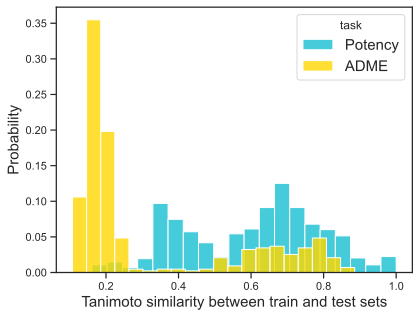

In [459]:
fig = plt.figure()
sns.histplot(
    df_pot.query("Set == 'Train'"), x="train_test_sim", color="tab:cyan",
    stat="probability", common_norm=False,bins=20,label="Potency",alpha=0.8, element="bars",edgecolor="white")
sns.histplot(df_adme.query("Set == 'Train'"), x="train_test_sim", color="gold",
    stat="probability", common_norm=False,bins=20,label="ADME",alpha=0.8,element="bars",edgecolor="white")
plt.xlabel("Tanimoto similarity between train and test sets",fontsize=15)
plt.ylabel("Probability",fontsize=15)
plt.legend(title="task",fontsize=15)
plt.show()
#fig.savefig("Fig2a_Histogram.svg", format="svg", bbox_inches="tight")

## Visualize Distribution and Correlation

<Figure size 1920x1440 with 0 Axes>

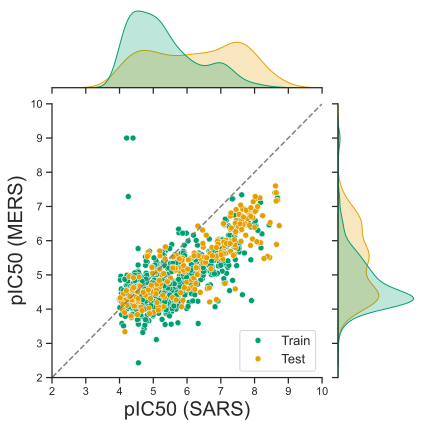

In [460]:
fig = plt.figure()

g = sns.jointplot(data=df_pot, x="SARS", y="MERS", hue="Set",marginal_kws={"common_norm": False},ratio=3,palette=["#009e73","#e69f00"],joint_kws={"alpha": 1})
plt.xlabel("pIC50 (SARS)",fontsize=20)
plt.ylabel("pIC50 (MERS)",fontsize=20)
plt.plot([0,10],[0,10],ls='--',color='gray')

plt.xlim([2,10])
plt.ylim([2,10])
plt.legend(loc="lower right",fontsize=13)
plt.show()
#g.fig.savefig("Fig2d_Potency_Scatter.svg", format="svg", bbox_inches="tight")

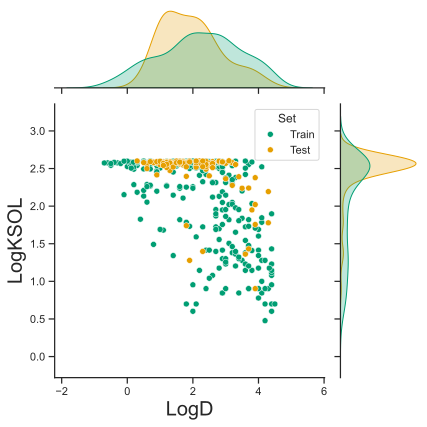

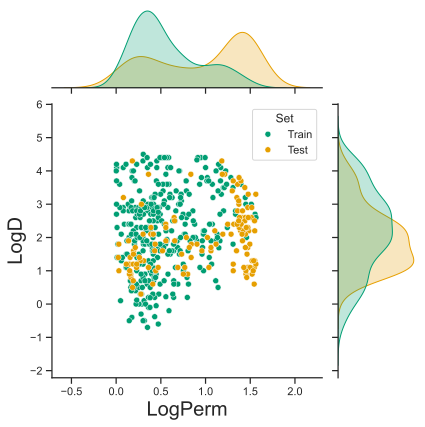

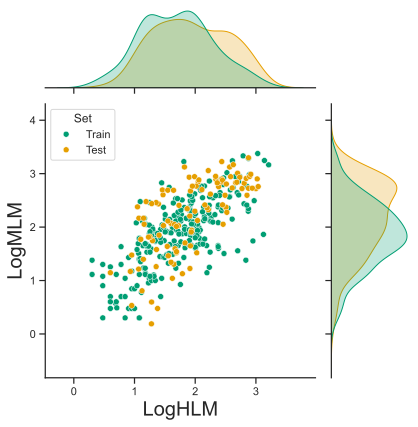

In [461]:
adme_pairs = [('LogD','LogKSOL'),('LogMDR1','LogD'),('LogHLM','LogMLM')]
for pair in adme_pairs:
    g = sns.jointplot(data=df_adme, x=pair[0], y=pair[1], hue="Set",marginal_kws={"common_norm": False},ratio=3,palette=["#009e73","#e69f00"])

    g.ax_joint.set_xlabel(pair[0], fontsize=20)
    g.ax_joint.set_ylabel(pair[1], fontsize=20)
    if "LogMDR1" in pair[0]:
        g.ax_joint.set_xlabel("LogPerm",fontsize=20)  
    #g.fig.savefig(f"Fig2_{pair[0]}_{pair[1]}_Scatter.svg", format="svg", bbox_inches="tight")
plt.show()

## Curation via cliff detection

In [217]:
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from scipy.stats import zscore, norm

fpdict = {}
fpdict['ecfp4'] = lambda m: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=2048,includeChirality=True).GetFingerprintAsNumPy(m)

def get_tanimoto_similarity(smi_1, smi_2):
    fg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048,includeChirality=True)
    mol_1, mol_2 = [Chem.MolFromSmiles(smi) for smi in [smi_1,smi_2]]
    fp_1,fp_2 = [fg.GetFingerprint(mol) for mol in [mol_1,mol_2]]
    return DataStructs.TanimotoSimilarity(fp_1, fp_2)


def agglo_clustering(df,smi_col="CXSMILES",n_clusters=500,similarity_thresh=None):
    df = df.copy()
    
    cluster_fp = np.stack(df[smi_col].apply(lambda x: fpdict['ecfp4'](Chem.MolFromSmiles(x))).values)
    distance = pdist(cluster_fp != 0, metric = 'jaccard')

    if similarity_thresh is None:
        clustering = AgglomerativeClustering(n_clusters=n_clusters,metric='precomputed',linkage='complete',distance_threshold=None)
    if similarity_thresh is not None:
        clustering = AgglomerativeClustering(distance_threshold=1-float(similarity_thresh),metric='precomputed',linkage='complete',n_clusters=None)
    cluster_labels = clustering.fit_predict(squareform(distance))

    df["agglo_cluster"] = cluster_labels
    return df
    
def get_activity_cliffs(df,y_col,set_col="Set",z_thresh=2.5,cluster_thresh=0.8,smi_col="CXSMILES"):
    df = df.copy()
    if "agglo_cluster" not in  df.columns:
        df["agglo_cluster"] = agglo_clustering(df,smi_col=smi_col)
    
    cluster_col = "agglo_cluster"
     
    df[f"SALI_{y_col}"] = df.apply(lambda row: np.max([np.abs(row[y_col] - df.iloc[j][y_col])/(1.05-get_tanimoto_similarity(row[smi_col],df.iloc[j][smi_col])) for j in df[df[cluster_col] == row[cluster_col]].index.to_series()]) if row[set_col] == "Train" else np.nan,axis=1)    
    
    df[f"z_SALI_{y_col}"] = zscore(df[f"SALI_{y_col}"],nan_policy='omit')
    df[f"is_cliff_{y_col}"] = df[f"z_SALI_{y_col}"].apply(lambda x: abs(x) > z_thresh)
    return df

In [206]:
df_pot =agglo_clustering(df_pot)
df_adme = agglo_clustering(df_adme)

In [207]:
for target in  ["SARS","MERS"]:
    df_pot = get_activity_cliffs(df_pot,y_col=target)

for endpoint in ['LogD', 'LogHLM', 'LogMLM', 'LogKSOL', 'LogMDR1']:
    df_adme = get_activity_cliffs(df_adme,y_col=endpoint)

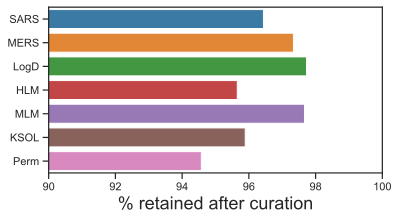

In [437]:


df_concat = pd.concat([df_pot,df_adme],ignore_index=True)

df_cliff = pd.DataFrame()
endpoints = ["SARS","MERS"] + ['LogD', 'LogHLM', 'LogMLM', 'LogKSOL', 'LogMDR1']
df_cliff["endpoint"] = endpoints
df_cliff["n_cliff"] = [df_concat.query("Set == 'Train'")[f"is_cliff_{endpoint}"].sum() for endpoint in endpoints]
df_cliff["frac_cliff"] = [df_concat.query("Set == 'Train'")[f"is_cliff_{endpoint}"].sum()/len(df_concat[~df_concat[endpoint].isna()].query("Set == 'Train'")) for endpoint in endpoints]

df_cliff["endpoint_name"] = df_cliff.endpoint.apply(lambda x: x.replace("Log","").replace("MDR1","Perm") if x != "LogD" else x)


f, ax = plt.subplots(figsize=(6, 3))
df_cliff["% retained"] = (1-df_cliff.frac_cliff)*100
ax = sns.barplot(df_cliff, y="endpoint_name", x="% retained",hue="endpoint",palette="tab10",alpha=0.95)
ax.get_legend().remove()
#ax.legend()
plt.xlim([90,100])
plt.xlabel("% retained after curation",fontsize=18)
plt.ylabel("")
#plt.legend(show=False)
plt.show()

In [218]:
df_cliff

endpoint  n_cliff  frac_cliff  % retained
0     SARS       30    0.035629   96.437055
1     MERS       24    0.026637   97.336293
2     LogD        8    0.022727   97.727273
3   LogHLM       13    0.043478   95.652174
4   LogMLM        7    0.023333   97.666667
5  LogKSOL       15    0.041096   95.890411
6  LogMDR1       23    0.054245   94.575472

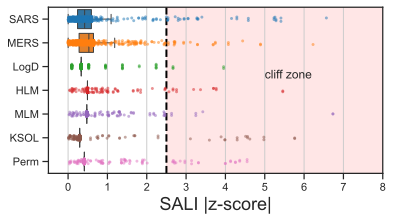

In [438]:

df_SALI = pd.DataFrame()
df_SALI["SALI"] = list(itertools.chain.from_iterable([df_concat[~df_concat[[f"SALI_{endpoint}"]].isna()][f"SALI_{endpoint}"] for endpoint in endpoints]))
df_SALI["z_SALI"] = list(itertools.chain.from_iterable([df_concat[~df_concat[[f"z_SALI_{endpoint}"]].isna()][f"z_SALI_{endpoint}"].apply(lambda x: np.abs(x)) for endpoint in endpoints]))
df_SALI["endpoint"] = list(itertools.chain.from_iterable([[endpoint for i in df_concat[~df_concat[[f"SALI_{endpoint}"]].isna()][f"SALI_{endpoint}"]] for endpoint in endpoints]))
df_SALI["endpoint_name"]  = df_SALI.endpoint.apply(lambda x: x.replace("Log","").replace("MDR1","Perm") if x != "LogD" else x)
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(df_SALI, x="z_SALI", y="endpoint_name", hue=None, palette="tab10",flierprops={"marker": "x", "markersize":0})

# Add in points to show each observation
sns.stripplot(df_SALI, x="z_SALI", y="endpoint_name", size=3, palette="tab10",alpha=0.5,marker='o')

# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set_xlim([-0.5,8])
ax.set(ylabel="")
plt.xlabel("SALI |z-score|",fontsize=18)
plt.axvline(x=2.5,ls="--",lw=2,color="black")
plt.axvspan(2.5,8, alpha=0.1, color='red',lw=0.5,zorder=0)
plt.annotate("cliff zone", (5,2.5))
plt.show()

# Impact of Data Curation

## Prepare 5x5 CV scaffold splits

In [247]:
# Use scaffold split

from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles
df_pot["scaffold_cluster"] = pd.factorize(df_pot["CXSMILES"].apply(MurckoScaffoldSmilesFromSmiles))[0]
df_adme["scaffold_cluster"] = pd.factorize(df_adme["CXSMILES"].apply(MurckoScaffoldSmilesFromSmiles))[0]

In [377]:

def get_stratCV_splits(df,y_col_to_stratify,group_col,n_splits=5,n_repeats=5,set_col="Set"):
    df = df.copy()
    #GroupedStratifiedKFold split 
    df_train = df.loc[df[set_col] == "Train",:]
    y_train_med  = df_train[y_col_to_stratify].median()
    strat_y = df_train[y_col_to_stratify].fillna(y_train_med) > y_train_med

    default_rand_list = [42,37,83,96,101]
    rand_list =  default_rand_list if n_repeats == 5 else np.random.randint(0, 199, size=n_repeats) #set 5x5 default for reproducibility
    counter = 1
    for rand_i in rand_list:
        rgss = StratifiedGroupKFold(n_splits=n_splits, shuffle=True,random_state=rand_i)
        for train_idx, val_idx in rgss.split(df_train.index.to_series(), strat_y, df_train[group_col]):
            df[f"CV_val_{counter}"] = df.index.isin(val_idx)
            counter += 1
    return df

In [249]:
df_pot = get_stratCV_splits(df_pot,"SARS","scaffold_cluster")
df_adme = get_stratCV_splits(df_adme,"LogD","scaffold_cluster")

## Check the distribution of validation split sizes

We expect the interquartile range (IQR) to be close to 0.2

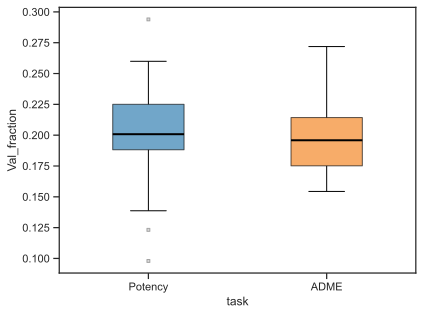

In [462]:
CV_cols = [col for col in df_pot.columns if "CV" in col] 

df_splits = pd.DataFrame()
df_splits["task"] = ["Potency"] * 25 + ["ADME"] * 25

pot_val_fraction = [int(df_pot[cv_col].sum())/len(df_pot.query("Set == 'Train'")) for cv_col in CV_cols] 
adme_val_fraction = [int(df_adme[cv_col].sum())/len(df_adme.query("Set == 'Train'")) for cv_col in CV_cols] 

df_splits["Val_fraction"] = pot_val_fraction + adme_val_fraction

ax = sns.boxplot(df_splits,
    x="task", y="Val_fraction", hue="task",showfliers=True, width=0.5,gap=0.2,palette=["tab:blue","tab:orange"],linewidth=1,linecolor='black',
    medianprops={"color": "black", "linewidth": 2},boxprops={"linewidth": 1, "alpha":0.65},flierprops=flierprops,saturation=0.9)


## Setup feature preprocessing pipeline

In [262]:
# Feature Preprocessing Pipeline

class RemoveAutocorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.95):
        self.threshold = threshold
    
    def fit(self, X, y=None):
        corr_matrix = np.corrcoef(X, rowvar=False)
        upper_triangle_indices = np.triu_indices_from(corr_matrix, k=1)
        self.to_remove_ = set()
        
        for i, j in zip(*upper_triangle_indices):
            if abs(corr_matrix[i, j]) > self.threshold:
                self.to_remove_.add(j)
        return self
    
    def transform(self, X, y=None):
        features_to_keep = [i for i in range(X.shape[1]) if i not in self.to_remove_]
        return X[:, features_to_keep]
    def get_support(self,X):
        mask = np.ones(X.shape[1], dtype=bool)
        mask[list(self.to_remove_)] = False
        return mask


def create_pipeline(model):
    pipeline = Pipeline([
        ('variance_threshold', VarianceThreshold(threshold=0.01)),
        ('autocorrel_threshold', RemoveAutocorrelatedFeatures(threshold=0.95)),
        ('algo', model)
    ])
    return pipeline

def get_regression_stats(y_true,y_pred):
    mask = ~np.isnan(y_true)
    y_true, y_pred = y_true[mask], y_pred[mask]

    regr_dict = { "MAE": mean_absolute_error(y_true, y_pred),
                "RMSE": (mean_squared_error(y_true, y_pred))**0.5,
                "pearsonr": pearsonr(y_true,y_pred)[0],
                "rho": spearmanr(y_true, y_pred)[0],
                "tau": r2_score(y_true, y_pred),
                "r2": kendalltau(y_true,y_pred).statistic}
    return regr_dict


## Prepare Molecular Features

In [251]:
from rdkit.Chem import AllChem, rdFingerprintGenerator, Descriptors

def get_rdkit_desc(df,smi_col="CXSMILES"):

    desc_names = [name for name, _ in Descriptors._descList]
    desc_funcs = [func for _, func in Descriptors._descList] 
    mols =  df[smi_col].apply(Chem.MolFromSmiles).values
    X_df = pd.DataFrame([[func(mol) for func in desc_funcs] for mol in mols],columns=desc_names)
    return X_df




## Cross-validation +  Benchmarking function 

In [384]:
def benchmark_models(df,model_dict,desc_dict,target_dict,set_col="Set",smi_col="CXSMILES",suspected_data_dict=None,task_name="Potency"):
    df = df.copy().reset_index(drop=True)
    reg_cols = ["target","model","desc","Set","CV","MAE","RMSE","pearsonr","rho","tau","r2"]
    df_eval = pd.DataFrame(columns=reg_cols)
    
    for model_name,desc_name in itertools.product(model_dict,desc_dict):
        model = model_dict.get(model_name)

        X = desc_dict.get(desc_name)
        print(f"Training started for {model_name} {desc_name} with shape {X.shape}")  

        CV_cols = [col for col in df.columns if "CV" in col]
        
        for target_name, target_col in target_dict.items():
            print("before curation",  len(df[~df[target_col].isna()]))  
            
            if suspected_data_dict is not None:
                df.loc[df[suspected_data_dict.get(target_name)], target_col] = np.nan      
            
            y = df[target_col].values
            mask_idx = np.where(~np.isnan(y))[0]
            print("after curation",  len(df[~df[target_col].isna()])) 


            for CV_id in CV_cols:
                CV_name = CV_id.replace("_val","")
                
                train_idx = df.iloc[mask_idx].loc[(df[CV_id] != True) & (df[set_col] == 'Train')].index.astype(int).to_numpy()
                val_idx = df.iloc[mask_idx].loc[(df[CV_id] == True) & (df[set_col] == 'Train')].index.astype(int).to_numpy()

                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y[train_idx], y[val_idx]  


                trained_val_model = model.fit(X_train,y_train)
                y_pred = model.predict(X)
                y_val_pred = y_pred[val_idx]

                val_stats = get_regression_stats(y_val,y_val_pred)
                print(f"model = {model_name} | desc = {desc_name} | target {target_name} | CV={CV_name} | MAE={val_stats.get("MAE"):.3f}")
                
                df_eval.loc[len(df_eval),:] = [target_name,model_name,desc_name,"Val",CV_name] + list(val_stats.values())
                df_eval.to_csv(f"./Eval_stat_{model_name}_{task_name}_.csv",index=False)
                #print(df_eval.sort_values(by="MAE").head(5))
    return df_eval


## Compare curated vs uncurated

In [ ]:


from sklearn.ensemble import RandomForestRegressor
n_estimators = 500
random_state = 42
RandomForest = create_pipeline(RandomForestRegressor(n_estimators=n_estimators,random_state=random_state)) 

model_dict = {}
model_dict["RF"] = RandomForest


X_pot_rdkit = get_rdkit_desc(df_pot.query("Set == 'Train'"))

desc_dict_pot = {}
desc_dict_pot["rdkit"] = X_pot_rdkit

target_dict_pot = {"SARS": "pIC50 (SARS-CoV-2 Mpro)",
                  "MERS":  "pIC50 (MERS-CoV Mpro)"}
 

suspected_data_dict_pot = {"SARS": "is_cliff_SARS", "MERS": "is_cliff_MERS"}

df_eval_RF_pot_uncurated = benchmark_models(df=df_pot.query("Set == 'Train'"),
                 model_dict=model_dict,
                 desc_dict=desc_dict,
                 target_dict=target_dict,
                 set_col="Set",
                 smi_col="CXSMILES",
                 suspected_data_dict=None,
                 task_name="Potency_uncurated")

df_eval_RF_pot_curated = benchmark_models(df=df_pot.query("Set == 'Train'"),
                 model_dict=model_dict,
                 desc_dict=desc_dict_pot,
                 target_dict=target_dict_pot,
                 set_col="Set",
                 smi_col="CXSMILES",
                 suspected_data_dict=suspected_data_dict_pot,
                 task_name="Potency_curated")

In [385]:
model_dict = {}
model_dict["RF"] = rf_r


X_adme_rdkit  =  get_rdkit_desc(df_adme.query("Set == 'Train'"))

desc_dict_adme = {}
desc_dict_adme["rdkit"] = X_adme_rdkit

target_dict_adme = {'LogD': 'LogD', 
                    'HLM': 'LogHLM', 
                    'MLM':'LogMLM', 
                    'Ksol':'LogKSOL', 
                    'Perm':'LogMDR1'}

suspected_data_dict_adme = {name: f"is_cliff_{val}" for name,val in target_dict_adme.items()}

df_eval_RF_adme_uncurated = benchmark_models(df=df_adme.query("Set == 'Train'"),
                 model_dict=model_dict,
                 desc_dict=desc_dict_adme,
                 target_dict=target_dict_adme,
                 set_col="Set",
                 smi_col="CXSMILES",
                 suspected_data_dict=None,
                 task_name="ADME_uncurated")

df_eval_RF_adme_curated = benchmark_models(df=df_adme.query("Set == 'Train'"),
                 model_dict=model_dict,
                 desc_dict=desc_dict_adme,
                 target_dict=target_dict_adme,
                 set_col="Set",
                 smi_col="CXSMILES",
                 suspected_data_dict=suspected_data_dict_adme,
                 task_name="ADME_curated")

Training started for RF rdkit with shape (434, 217)
before curation 352
after curation 352
model = RF | desc = rdkit | target LogD | CV=CV_1 | MAE=0.582
model = RF | desc = rdkit | target LogD | CV=CV_2 | MAE=0.542
model = RF | desc = rdkit | target LogD | CV=CV_3 | MAE=0.557
model = RF | desc = rdkit | target LogD | CV=CV_4 | MAE=0.688
model = RF | desc = rdkit | target LogD | CV=CV_5 | MAE=0.740
model = RF | desc = rdkit | target LogD | CV=CV_6 | MAE=0.610
model = RF | desc = rdkit | target LogD | CV=CV_7 | MAE=0.517
model = RF | desc = rdkit | target LogD | CV=CV_8 | MAE=0.528
model = RF | desc = rdkit | target LogD | CV=CV_9 | MAE=0.926
model = RF | desc = rdkit | target LogD | CV=CV_10 | MAE=0.559
model = RF | desc = rdkit | target LogD | CV=CV_11 | MAE=0.648
model = RF | desc = rdkit | target LogD | CV=CV_12 | MAE=0.463
model = RF | desc = rdkit | target LogD | CV=CV_13 | MAE=0.652
model = RF | desc = rdkit | target LogD | CV=CV_14 | MAE=0.609
model = RF | desc = rdkit | target L

In [400]:
df_eval_RF_pot_curated["is_curated"] = True
df_eval_RF_pot_uncurated["is_curated"] = False

df_eval_RF_adme_curated["is_curated"] = True
df_eval_RF_adme_uncurated["is_curated"] = False

df_curation = pd.concat([df_eval_RF_pot_uncurated,df_eval_RF_adme_uncurated,df_eval_RF_pot_curated,df_eval_RF_adme_curated],ignore_index=True)


## Normality Diagnostic

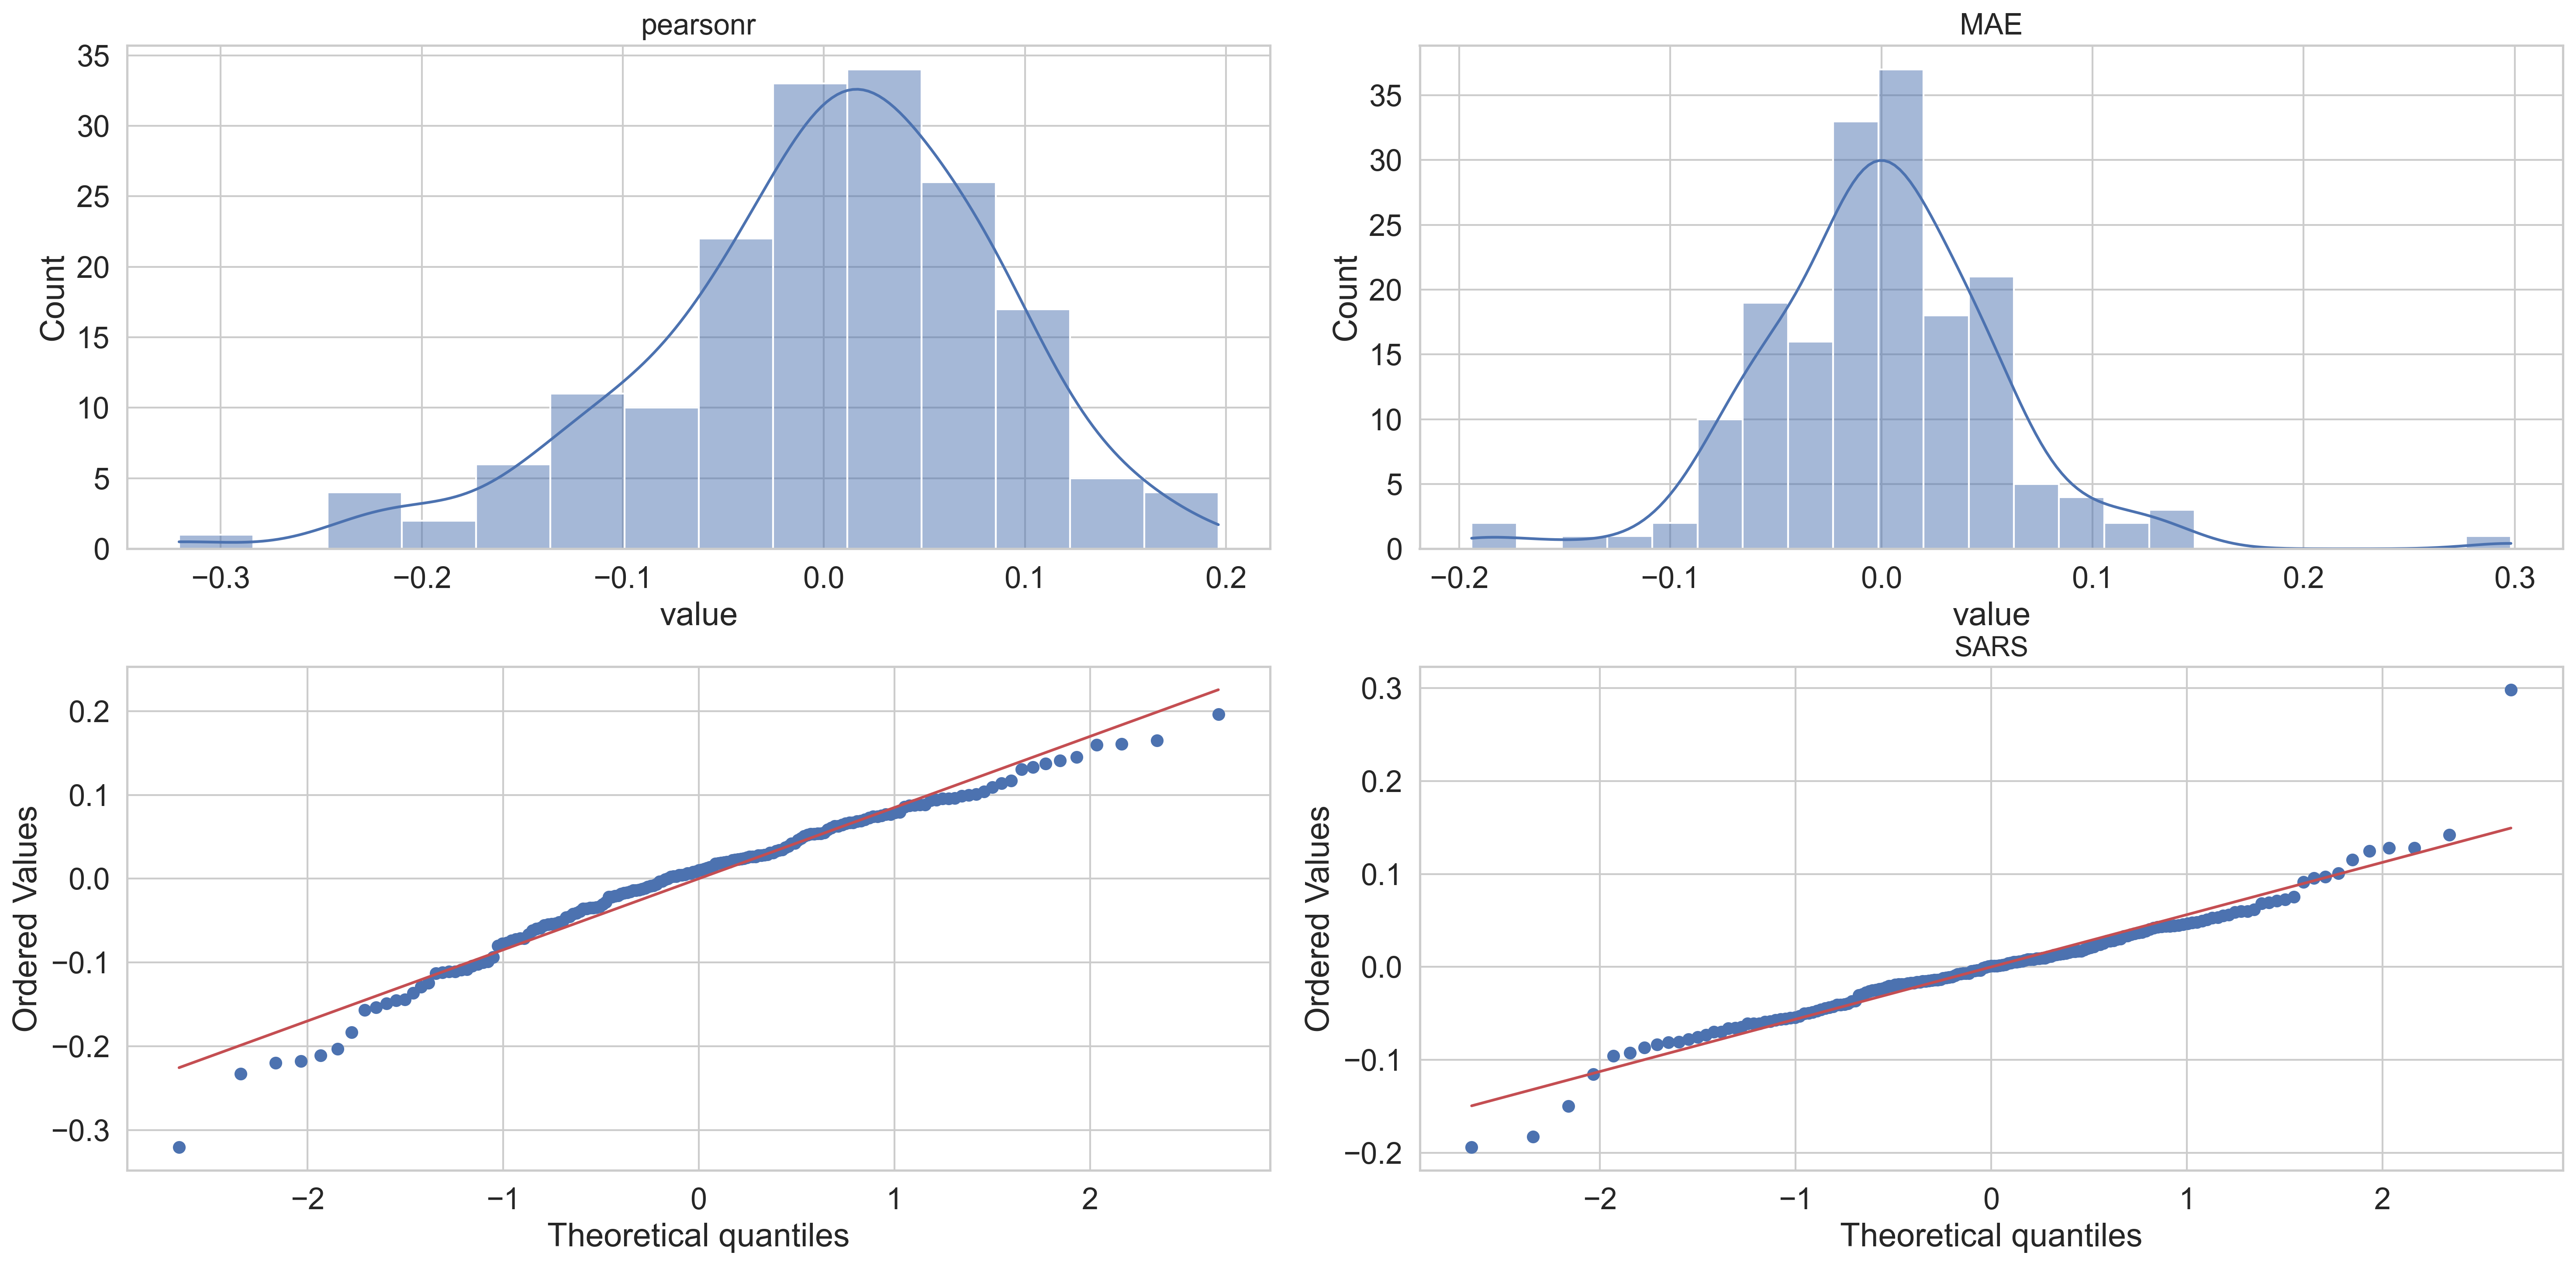

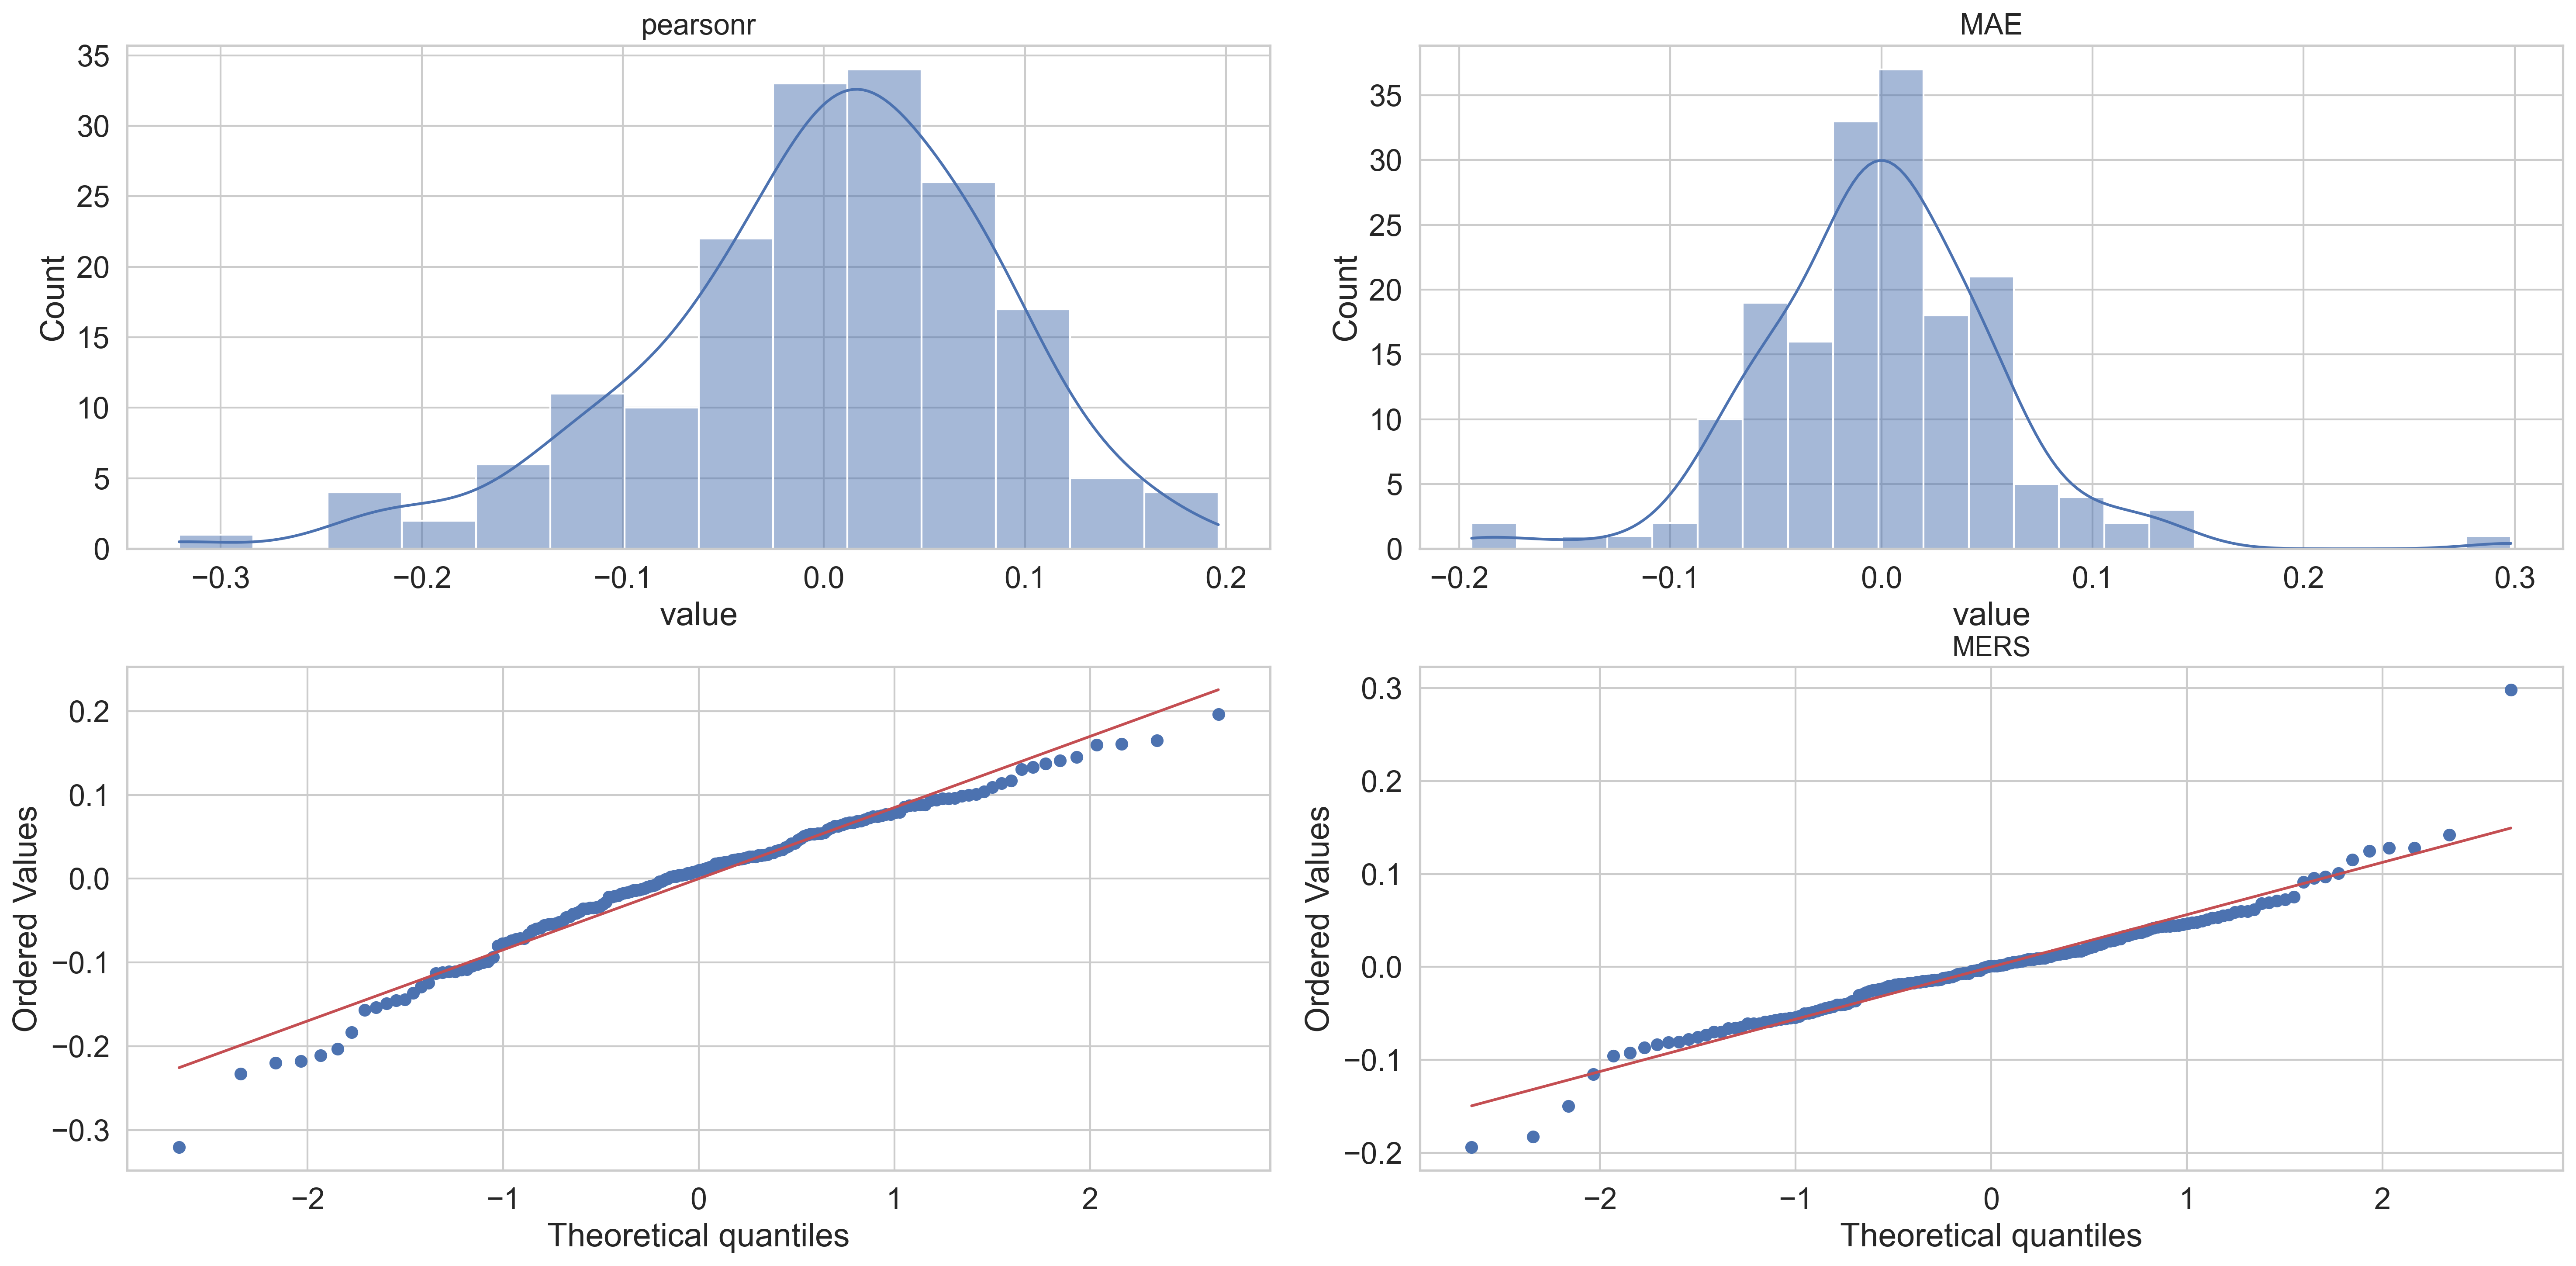

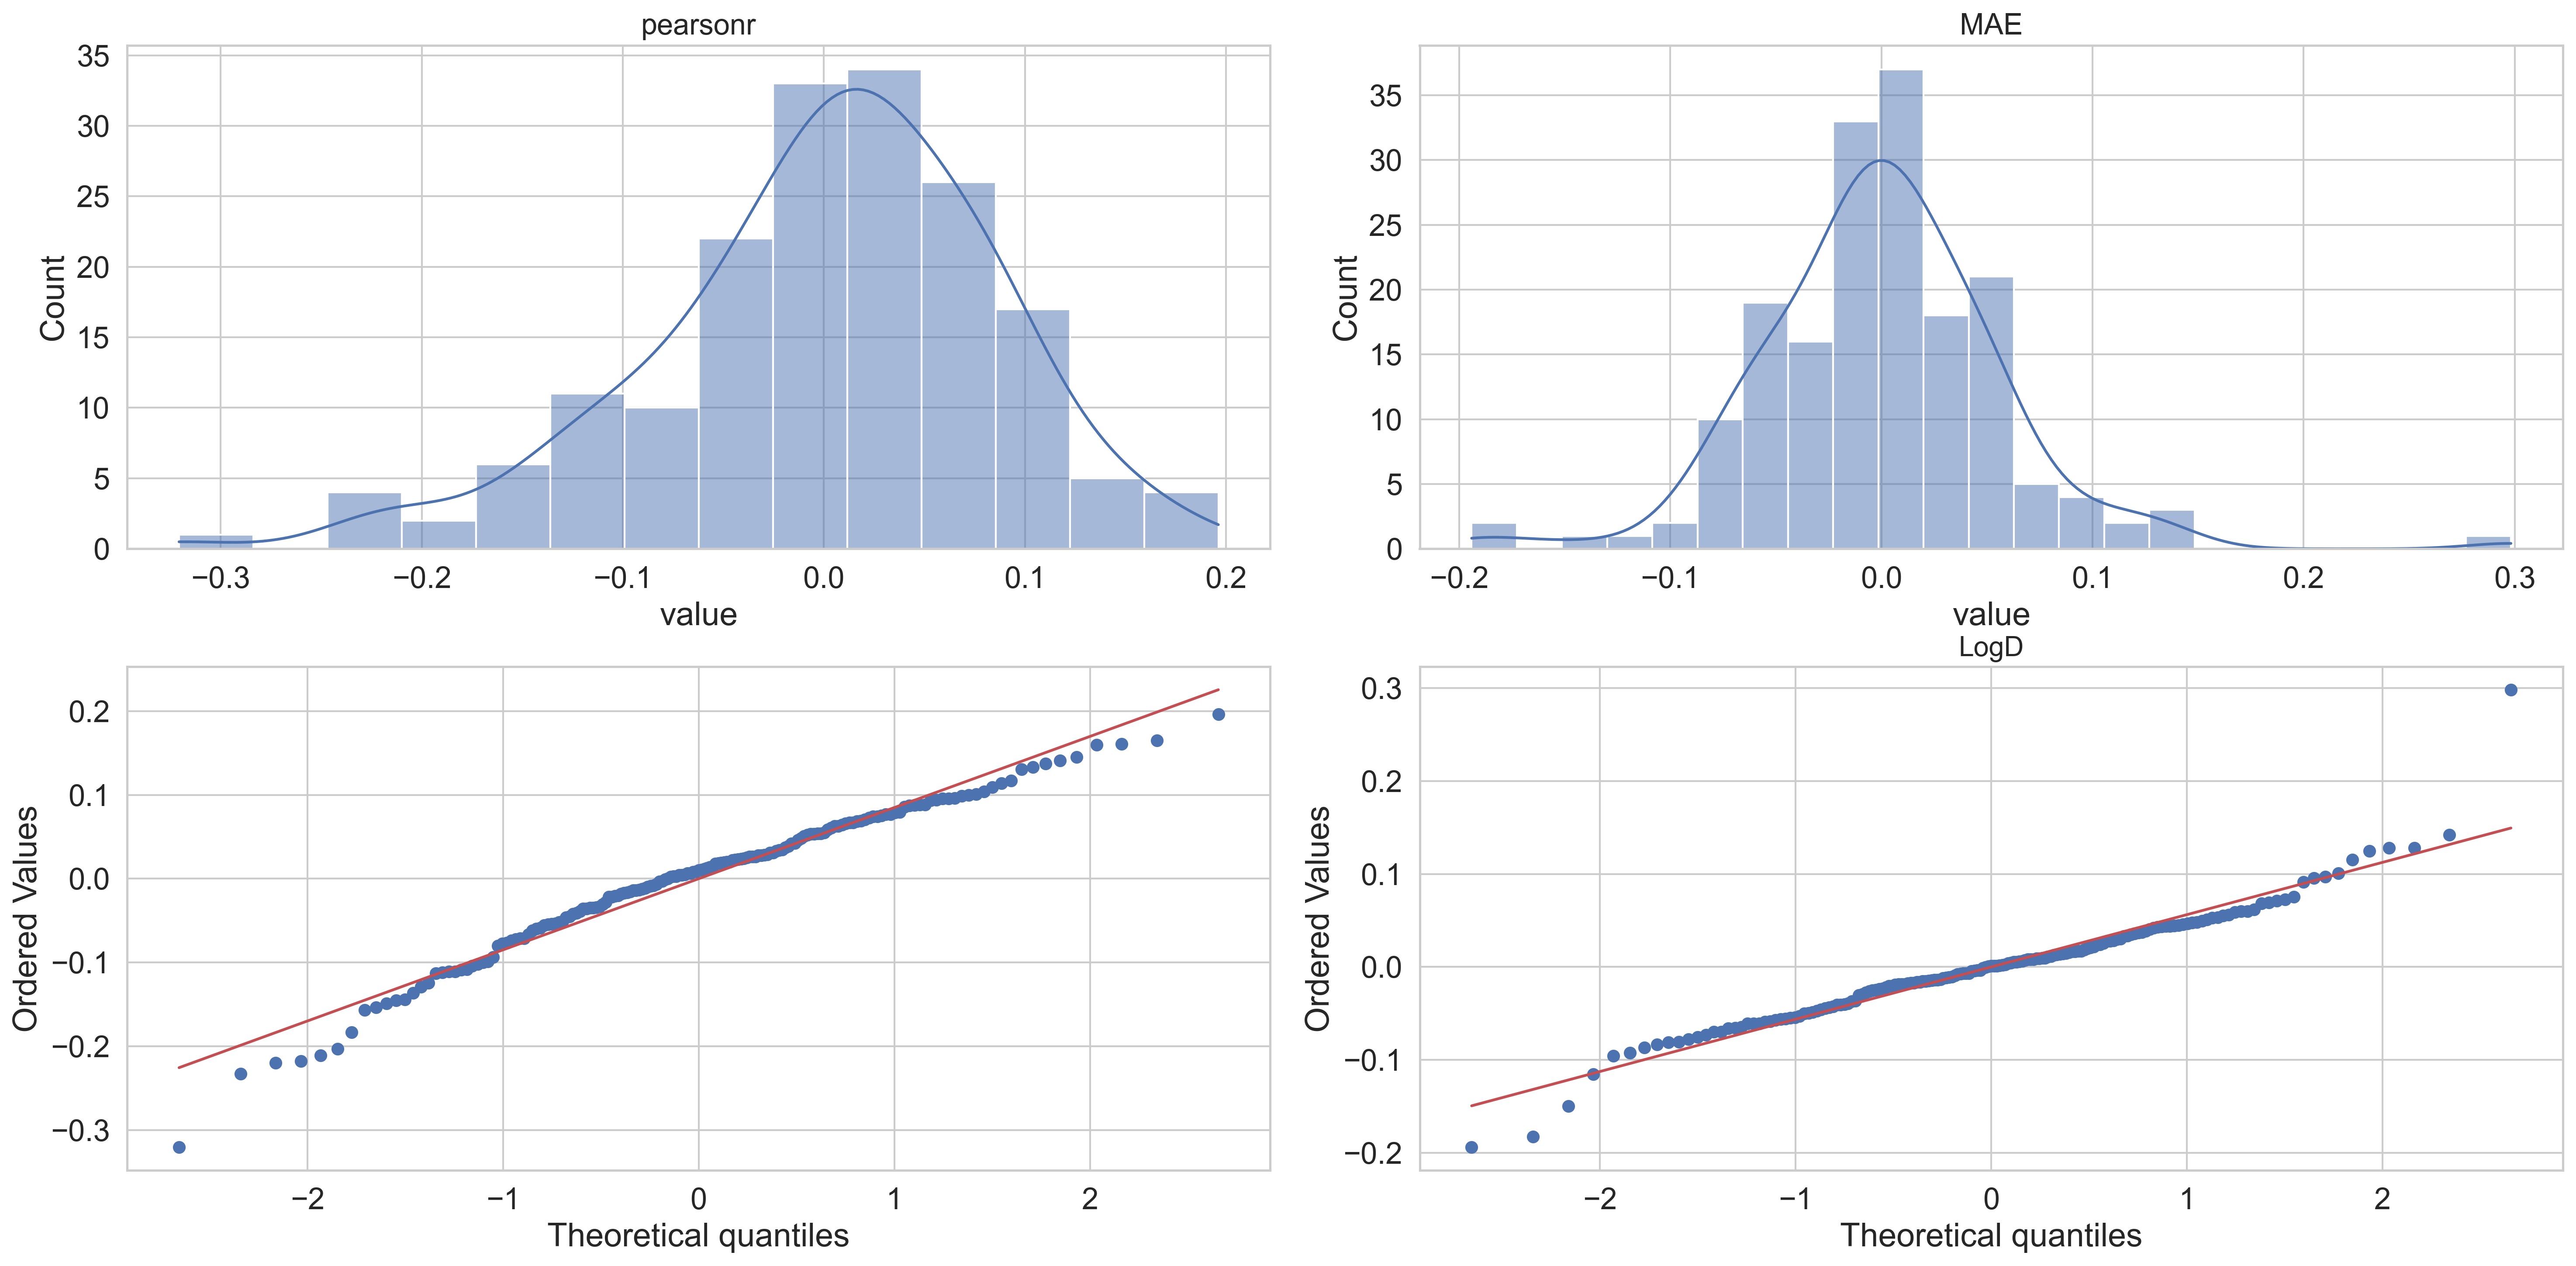

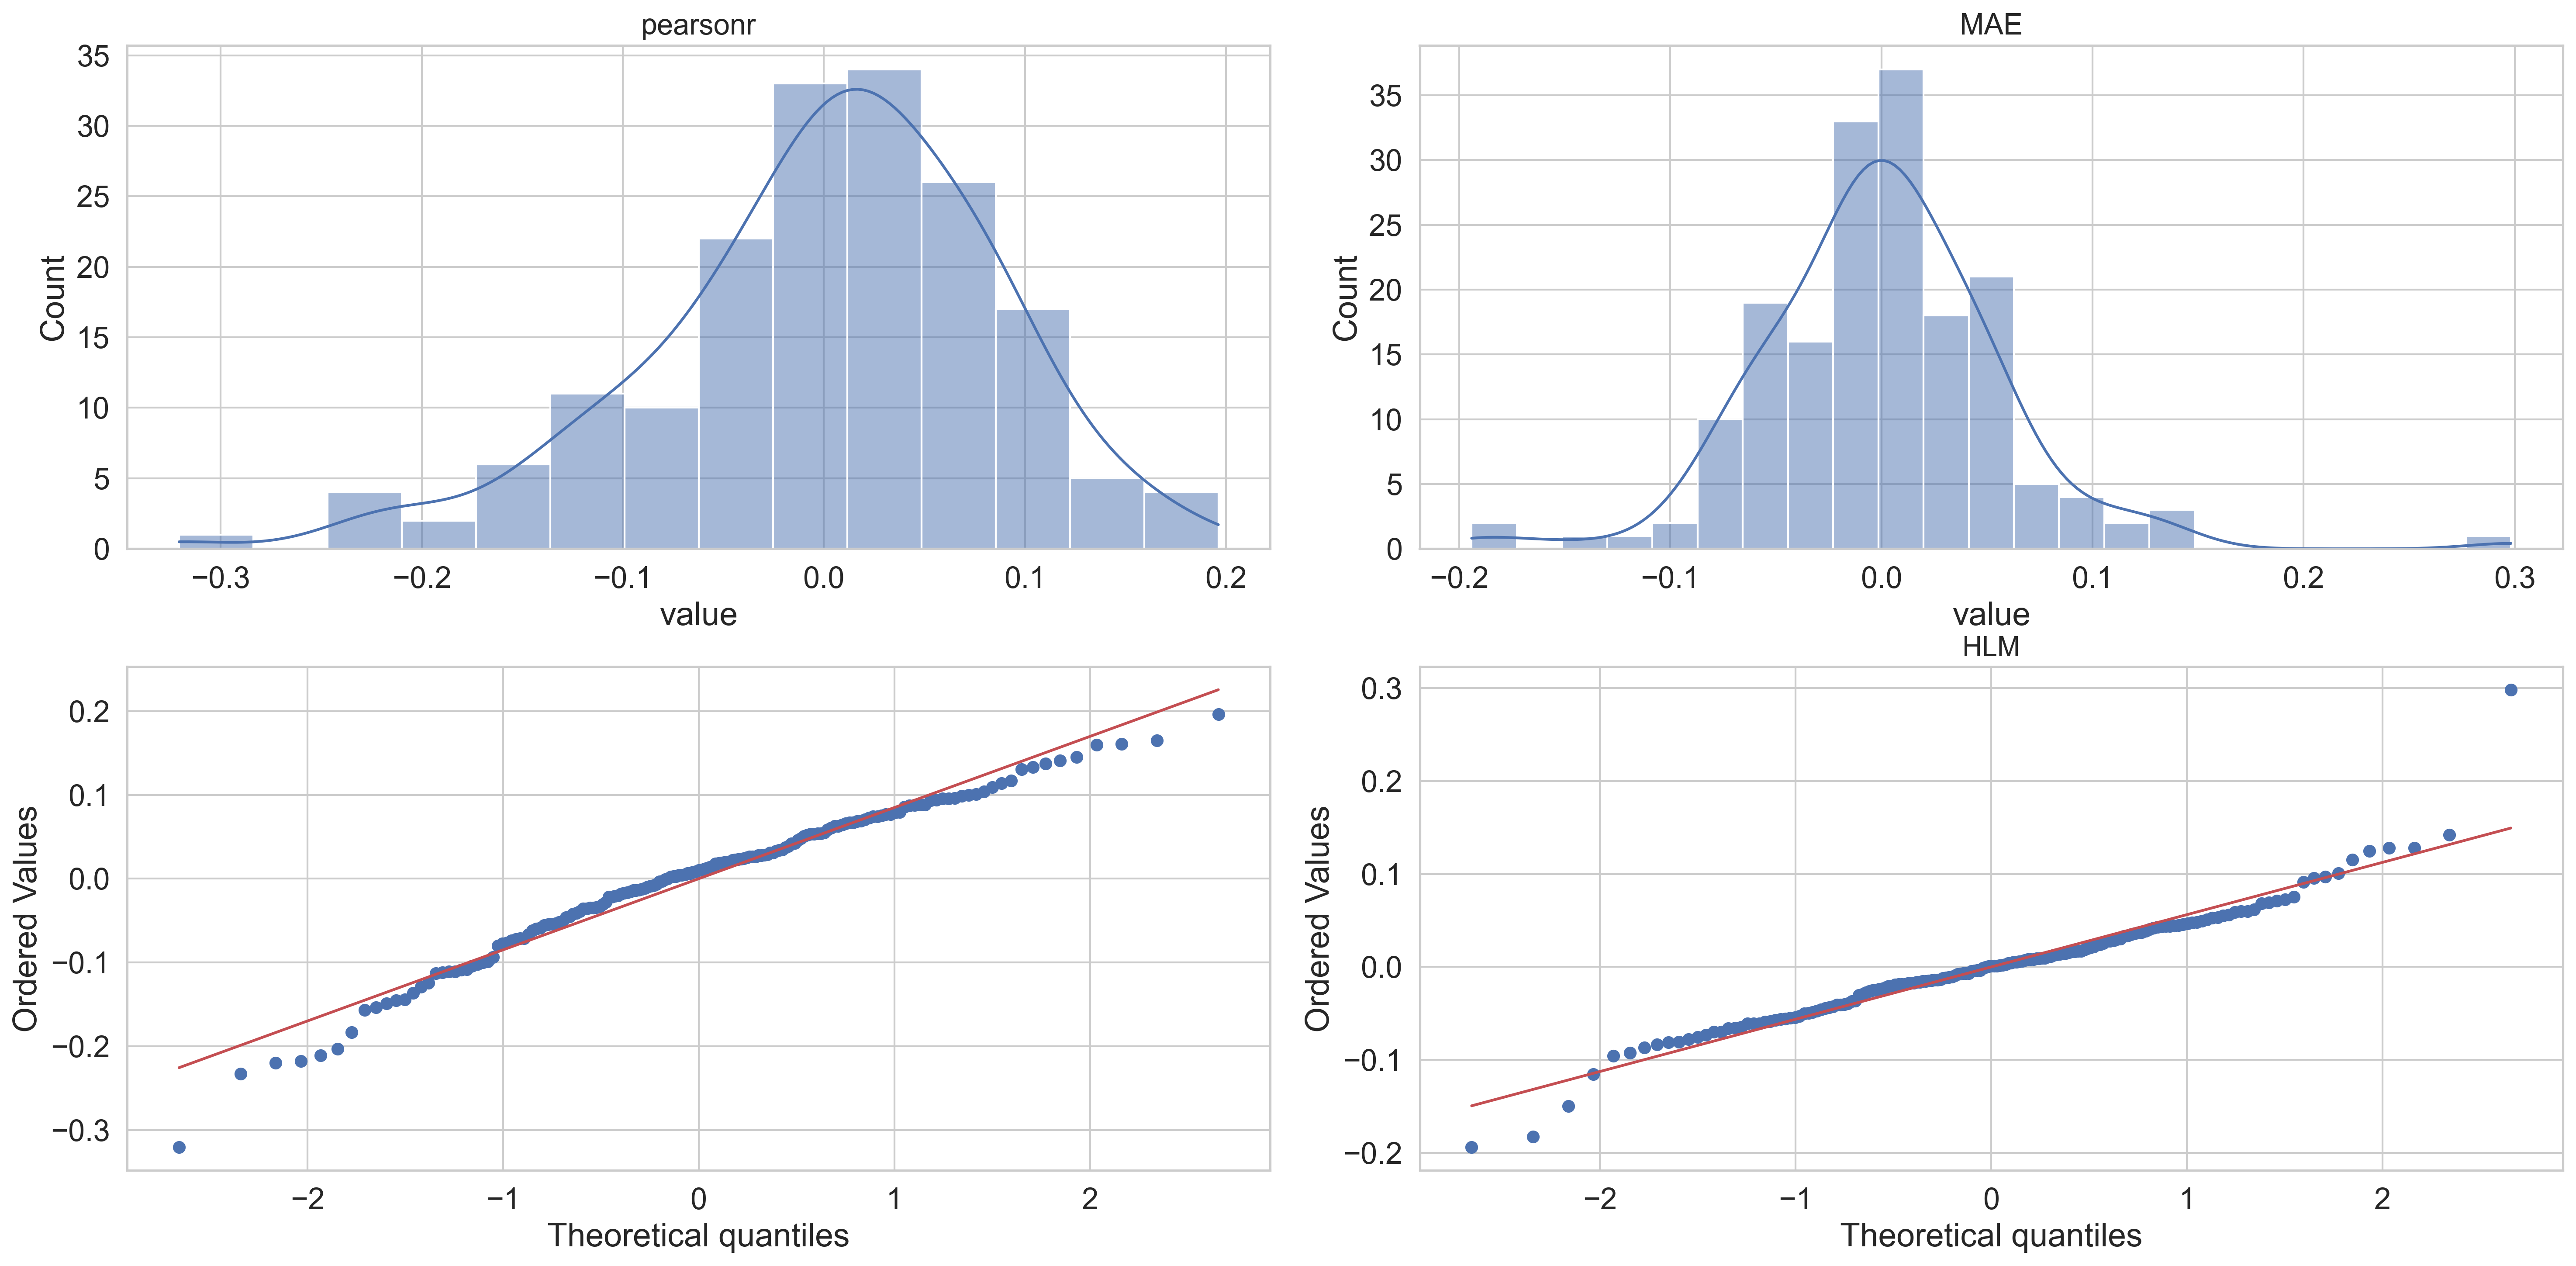

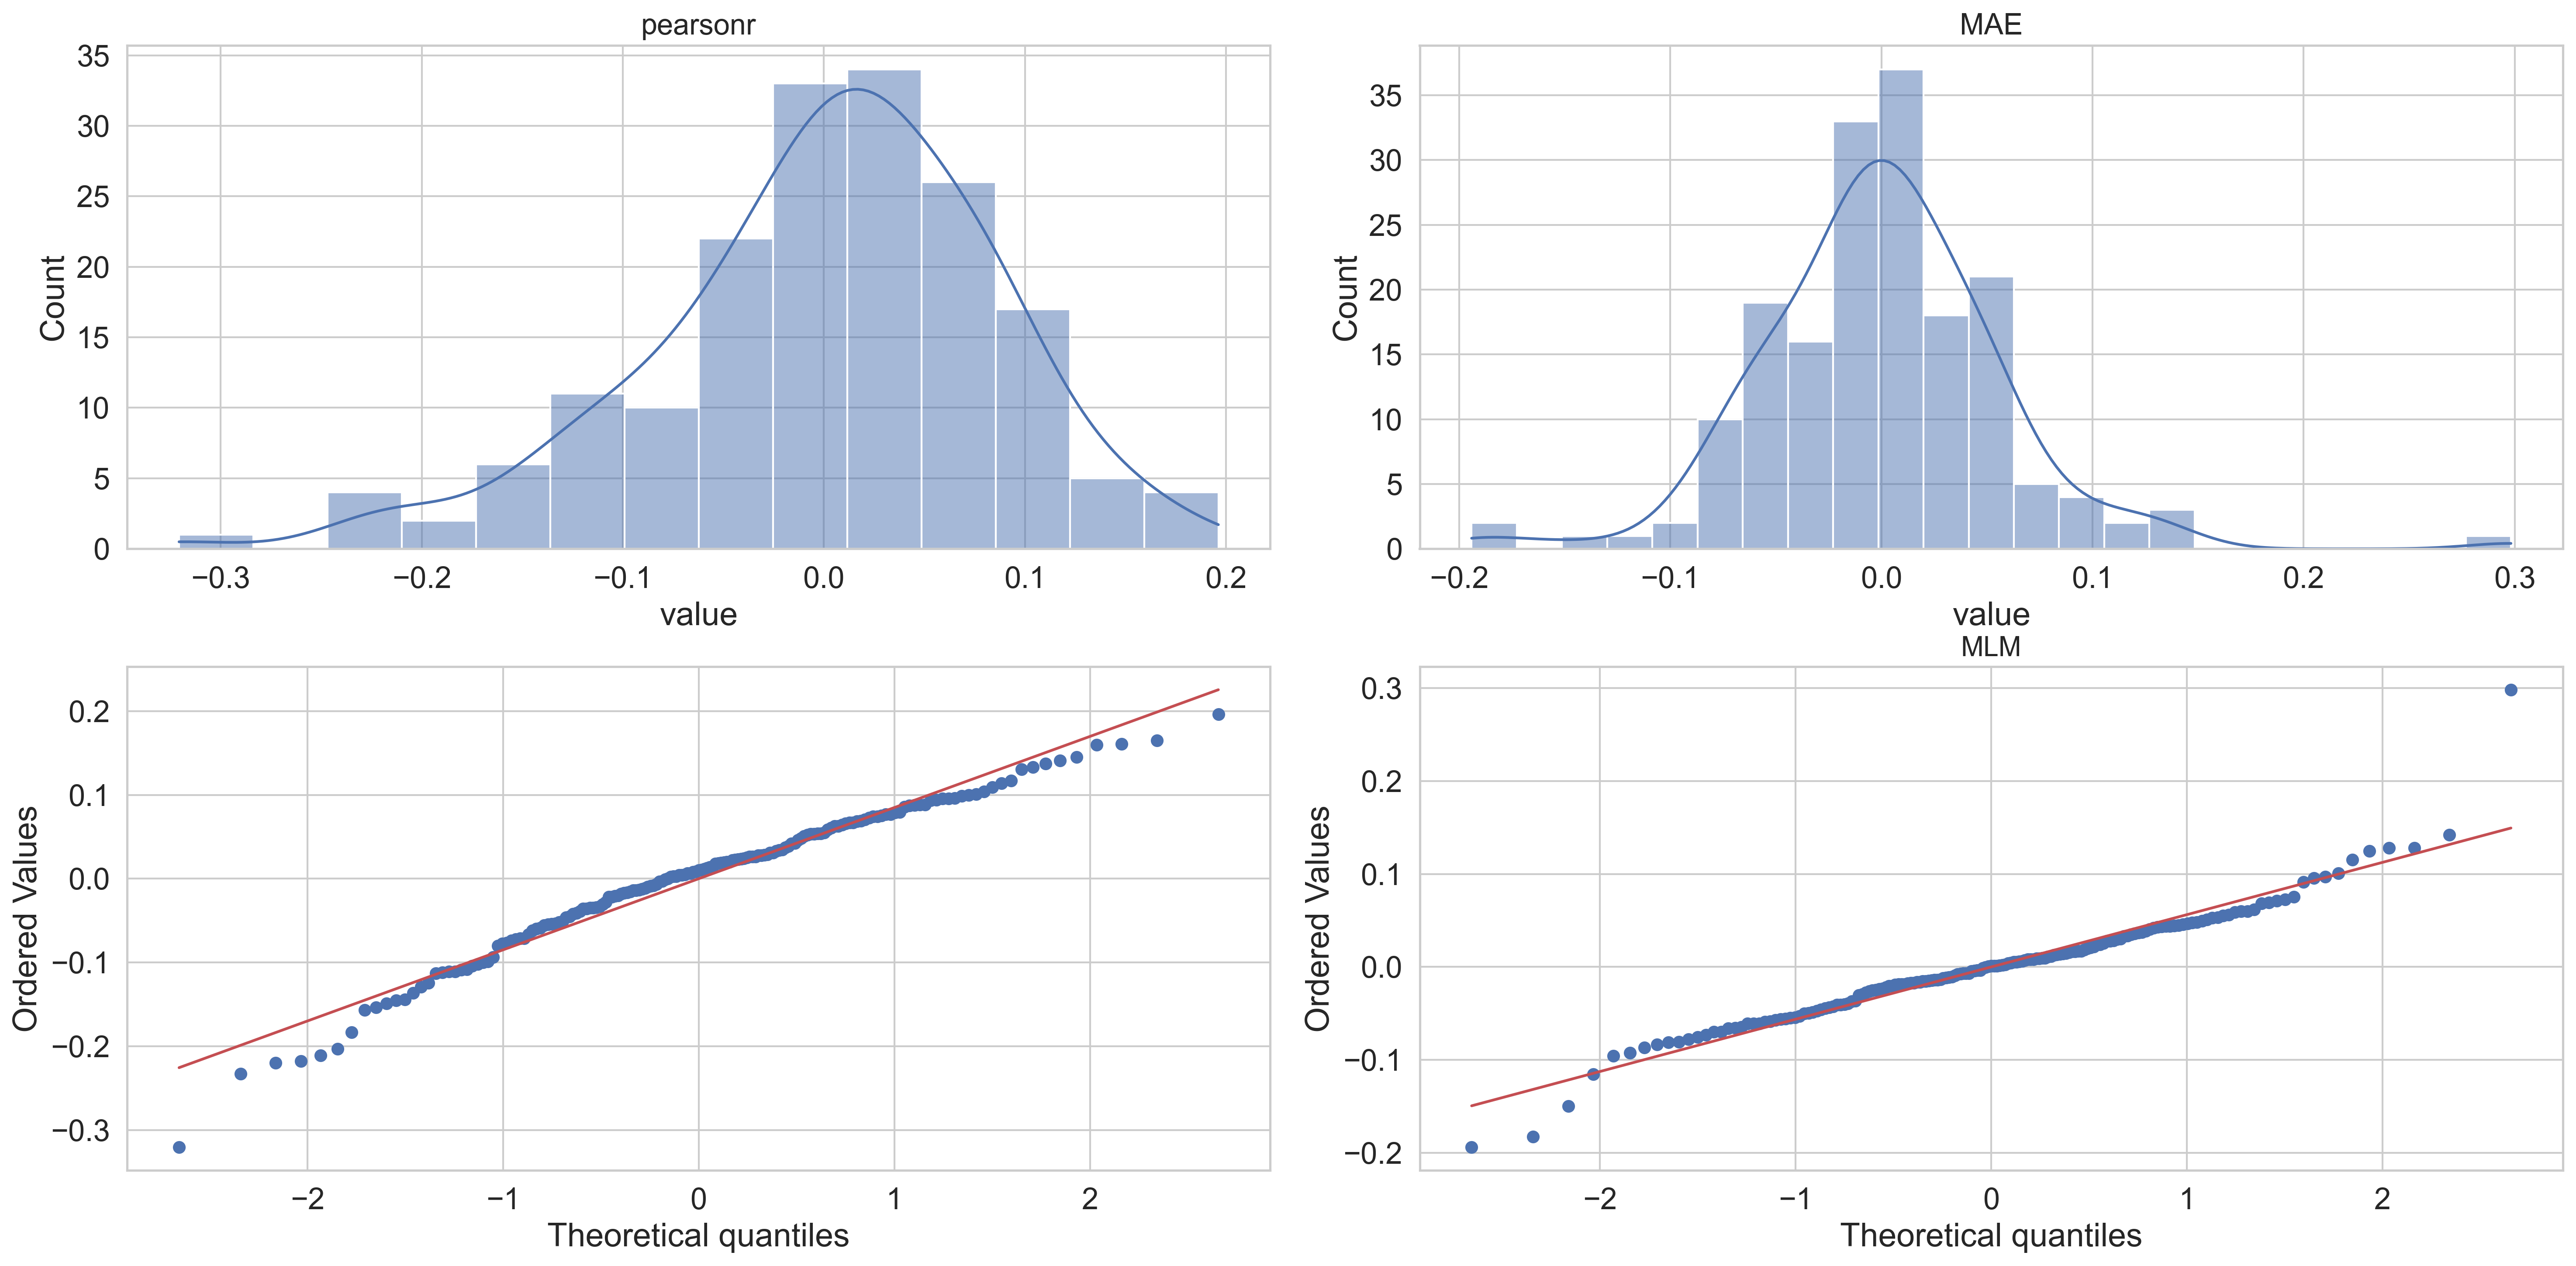

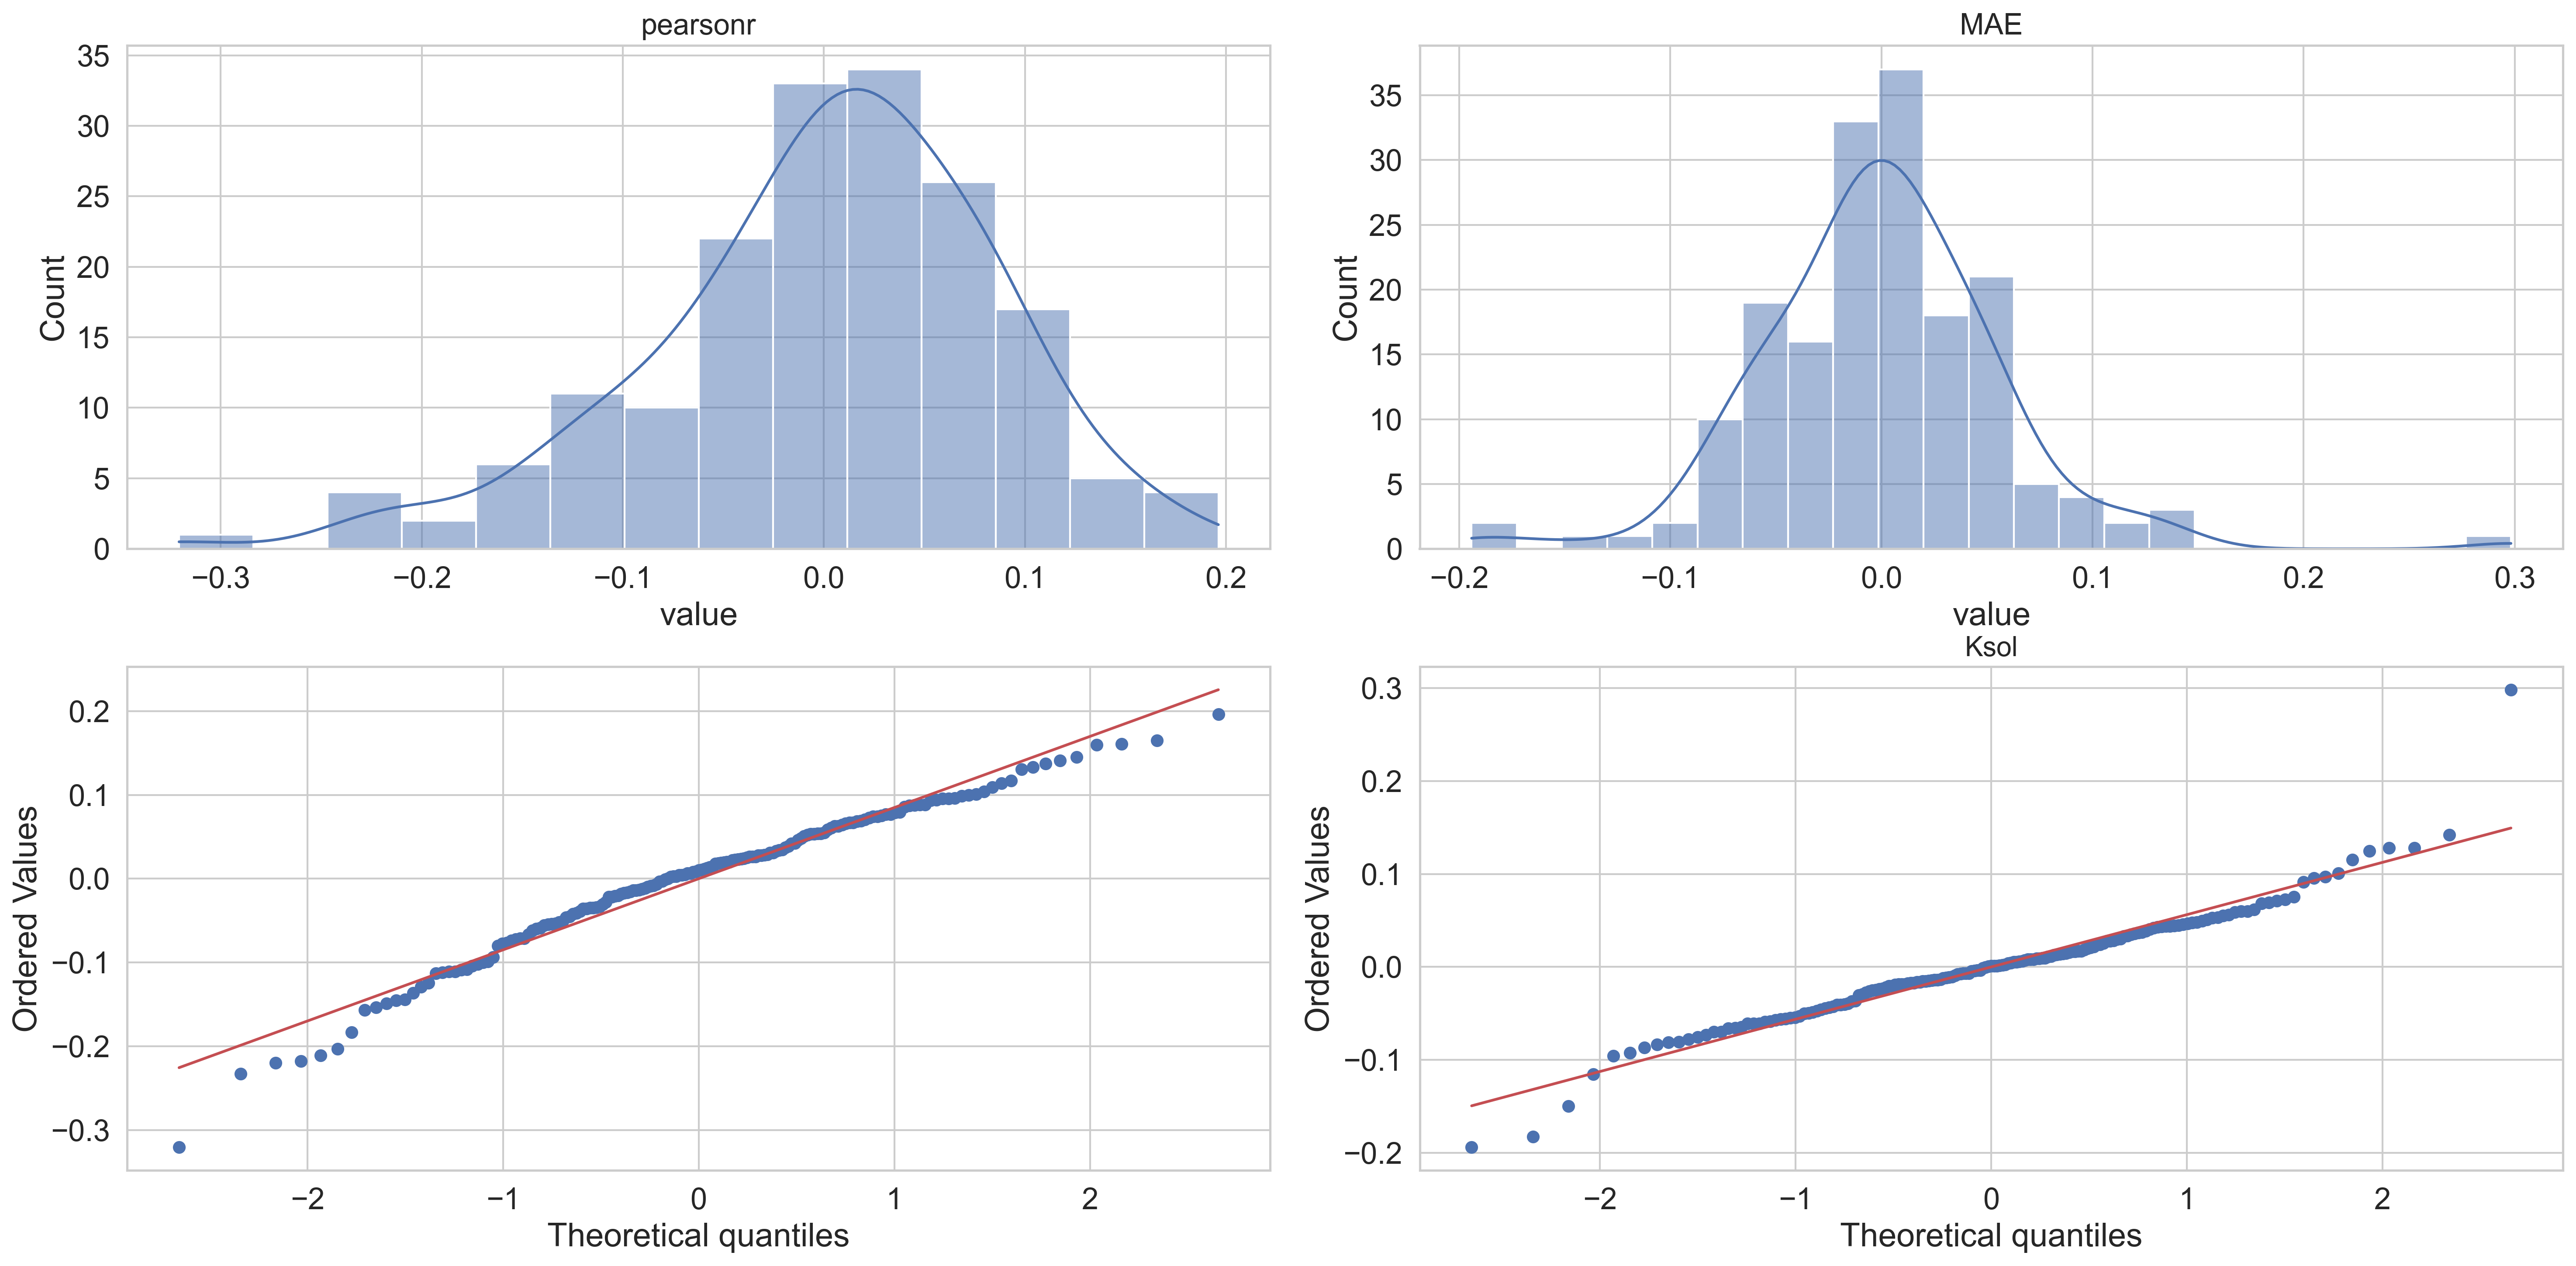

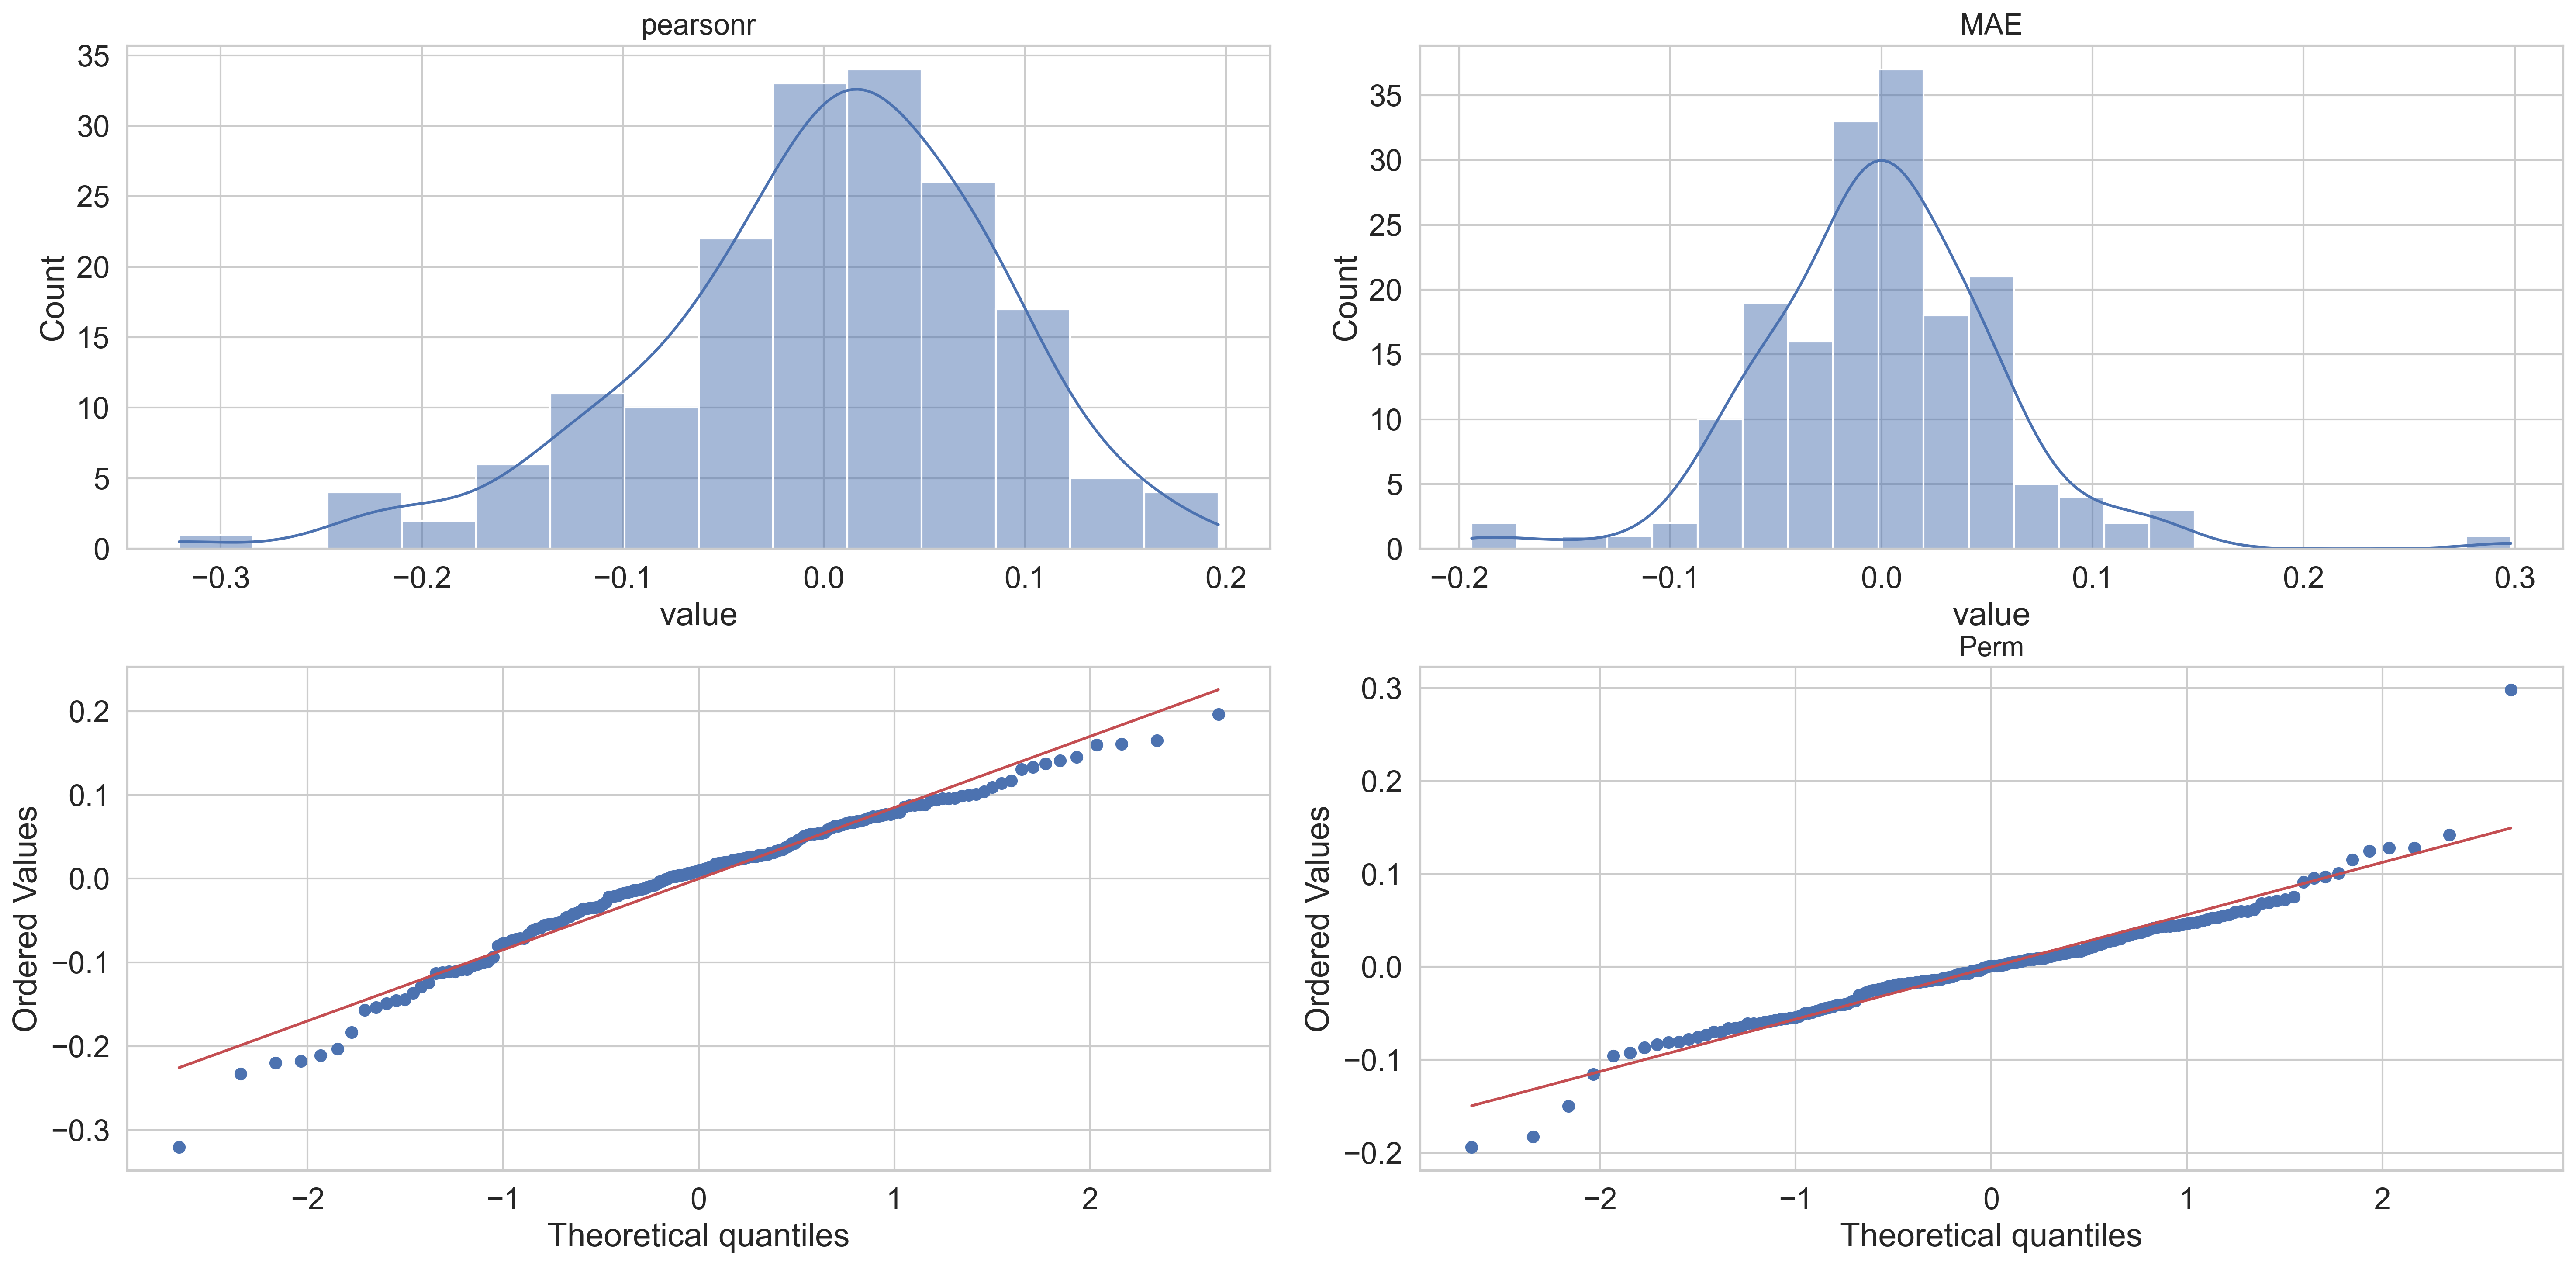

In [401]:
df_curation["pearsonr"] = df_curation["pearsonr"].astype(float)
df_curation["MAE"] = df_curation["MAE"].astype(float)
for target in df_curation.target.unique():
    make_normality_diagnostic(df_curation.query(f"is_curated and Set == 'Val' and model == 'RF' and desc =='rdkit'").reset_index(drop=True),["pearsonr","MAE"],"target")
    plt.title(target,fontsize=15)
    plt.show()

## Statistical Analysis using RM-Anova + Tukey HSD

In [392]:
import model_comparison
import importlib
importlib.reload(model_comparison)

from model_comparison import rm_tukey_hsd, make_normality_diagnostic

import bisect

def pval_to_asterisk(p):
    thresholds = [0.0001, 0.001, 0.01, 0.05, float("inf")]
    symbols = ["****", "***", "**", "*", r"$^{\mathrm{ns}}$"]
    return symbols[bisect.bisect_left(thresholds, p)]

def get_pvalue_rm_tukeyhsd(df,endpoint_name="LogD",stat="pearsonr",group_col="method",endpoint_col="target",CV_col="CV"):
    df_to_test =df[df[endpoint_col] == endpoint_name]
    df_to_test[stat] = df_to_test[stat].astype(float)
    result_tab, *_ = rm_tukey_hsd(df_to_test,metric=stat,group_col=group_col,CV_col=CV_col)
    return float(result_tab['p-adj'].values[0])

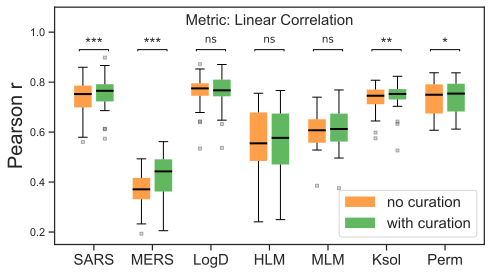

In [458]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
sns.set_palette("deep",desat=1) 
plt.figure(figsize=(7, 4))


df_curate_RF = df_curation.query("Set == 'Val' and (model == 'RF') and desc == 'rdkit'")
df_curate_RF["group_col"] = df_curate_RF["is_curated"].astype(int)

flierprops = dict(marker='s', markersize=3, markerfacecolor='gray', alpha=0.3)
ax = sns.boxplot(df_curate_RF,
    x="target", y="pearsonr", hue="is_curated",showfliers=True, width=0.75,gap=0.2,palette=nature_palette,linewidth=1,linecolor='black',
    medianprops={"color": "black", "linewidth": 2},boxprops={"linewidth": 0,"alpha":0.75},flierprops=flierprops, saturation=1)



tukey_pval = [get_pvalue_rm_tukeyhsd(df_curate_RF,endpoint_name=i,stat="pearsonr",group_col="is_curated") for i in df_curate_RF.target.unique()]


plt.xlabel("",fontsize=8)
plt.ylabel("Pearson r", fontsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["no curation","with curation"], title="",loc="lower right",fontsize=15)


y_position = 0.95
for i,endpoint in enumerate(df_curation.target.unique()):   
    y=y_position-0.025 ; h=0.005
    x1 = i-0.25
    x2 = i+0.25
    plt.text(x=np.mean([x1,x2]), y=y+h+0.005, s=pval_to_asterisk(tukey_pval[i]),fontsize=15, ha='center')
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, color="black")
    
plt.title("Metric: Linear Correlation",y=0.9,fontsize=15)
plt.ylim([0.15,1.1])
plt.xticks(fontsize=15)
plt.tight_layout() 
plt.show()

In [409]:
from sklearn.metrics import mean_absolute_error
def get_baseline_MAE(df,endpoint_col,set_col="Set"):
    y_true = df[df[set_col] == "Train"][endpoint_col].dropna().values
    y_pred = [np.mean(y_true)] * len(y_true)
    return mean_absolute_error(y_true, y_pred)

baseline_MAE_dict = {}

for endpoint in ["SARS","MERS"]:
    baseline_MAE_dict[endpoint] = get_baseline_MAE(df_pot,endpoint)

for endpoint in ['LogD', 'HLM', 'MLM', 'Ksol', 'Perm']:
    baseline_MAE_dict[endpoint] = get_baseline_MAE(df_adme,target_dict_adme.get(endpoint))

def get_RAE(df,target_col="target",MAE_col="MAE"):
    df = df.copy()
    df[MAE_col] = df[MAE_col].astype(float)
    df["RAE"] = df.apply(lambda row: row[MAE_col]/baseline_MAE_dict.get(row[target_col]),axis=1)
    df["RDA"] = df["RAE"].apply(lambda x: 1 -x )
    return df


df_curation["RAE"] = df_curation.apply(lambda row: float(row["MAE"])/float(baseline_MAE_dict.get(row["target"])),axis=1)
df_curation["RDA"] =  df_curation["RAE"].apply(lambda x: 1 -x )

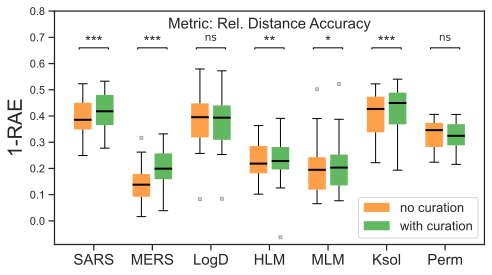

In [727]:
plt.rcParams['figure.facecolor'] = 'none'
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")
sns.set_palette("deep",desat=1) 
plt.figure(figsize=(7, 4))


df_curate_RF = df_curation.query("Set == 'Val' and (model == 'RF') and desc == 'rdkit'")
df_curate_RF["group_col"] = df_curate_RF["is_curated"].astype(int)

flierprops = dict(marker='s', markersize=3, markerfacecolor='gray', alpha=0.3)
ax = sns.boxplot(df_curate_RF,
    x="target", y="RDA", hue="is_curated",showfliers=True, width=0.75,gap=0.2,palette=nature_palette,linewidth=1,linecolor='black',
    medianprops={"color": "black", "linewidth": 2},boxprops={"linewidth": 0,"alpha":0.75},flierprops=flierprops, saturation=1)



tukey_pval = [get_pvalue_rm_tukeyhsd(df_curate_RF,endpoint_name=i,stat="RDA",group_col="is_curated") for i in df_curate_RF.target.unique()]


plt.xlabel("",fontsize=15)
plt.ylabel("1-RAE", fontsize=20)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=["no curation","with curation"], title="",loc="lower right",fontsize=13)
#ax.set_xticklabels(["SARS", "MERS", "LogD", "HLM","MLM","Ksol","MDR1"],fontsize=15)

y_position = 0.68
for i,endpoint in enumerate(df_curation.target.unique()):   
    y=y_position-0.025 ; h=0.005
    x1 = i-0.25
    x2 = i+0.25
    plt.text(x=np.mean([x1,x2]), y=y+h+0.005, s=pval_to_asterisk(tukey_pval[i]),fontsize=15, ha='center')
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, color="black")
    
plt.title("Metric: Rel. Distance Accuracy",y=0.9,fontsize=15)
plt.ylim([-0.09,0.8])
plt.xticks(fontsize=15)
plt.tight_layout() 
plt.show()

# Benchmarking Molecular Representations

In [16]:
import pandas as pd 
df_model = pd.read_csv("./Polaris_Model_Benchmark_Results.csv")

In [17]:
df_model["model_name"] = df_model["model_name"].apply(lambda x: x.replace("Support Vector Machine","SVM")) 

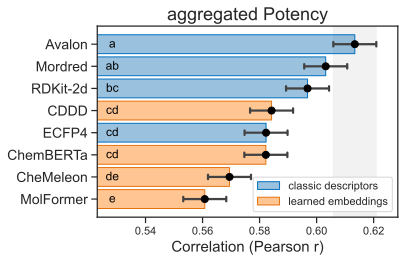

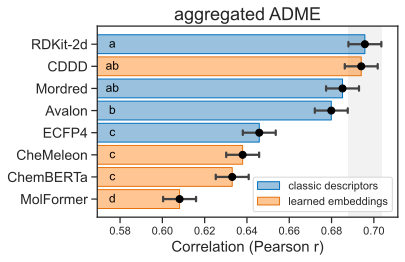

In [678]:

import model_comparison
import importlib
importlib.reload(model_comparison)
from model_comparison import get_tukey_barplot

group_color_dict = {
        "no extra features": "tab:orange",
        "with extra features":  "tab:blue"
}




for target in ["aggregated Potency","aggregated ADME"]:
    df_i = df_model[df_model.model.isin(["LGBM","RF"])]
    df_i = df_i[df_model.desc_name.isin(["Avalon","RDKit-2d","Mordred","ECFP4","CDDD","ChemBERTa","MolFormer","CheMeleon"])].query(f"Set == 'Val' and target == '{target}'")
    get_tukey_barplot(df_i,metric="pearsonr",group_col="desc_name",CV_col="CV",xlabel="Correlation (Pearson r)",ylabel=None,title=target,palette="tab10",hue="desc type",legend_title="")
    



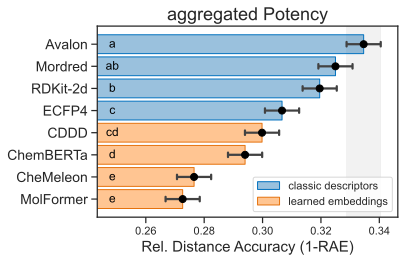

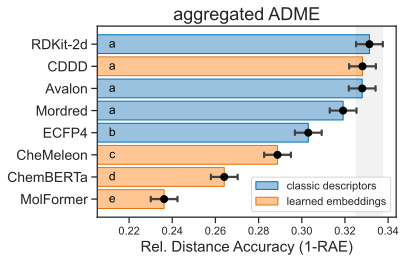

In [679]:

for target in ["aggregated Potency","aggregated ADME"]:
    df_i = df_model[df_model.model.isin(["LGBM","RF"])]
    df_i = df_i[df_model.desc_name.isin(["Avalon","RDKit-2d","Mordred","ECFP4","CDDD","ChemBERTa","MolFormer","CheMeleon"])].query(f"Set == 'Val' and target == '{target}'")
    get_tukey_barplot(df_i,metric="RDA",group_col="desc_name",CV_col="CV",xlabel="Rel. Distance Accuracy (1-RAE)",ylabel=None,title=target,palette="tab10",hue="desc type",legend_title="")



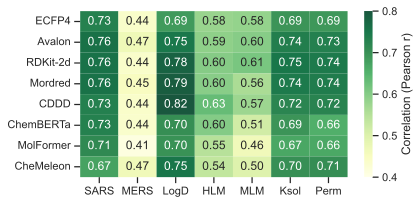

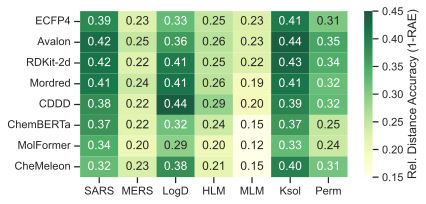

In [1051]:

fig = plt.figure(figsize=(6,3))

row_order = ['ECFP4','Avalon','RDKit-2d', 'Mordred','CDDD','ChemBERTa','MolFormer','CheMeleon']
col_order = ['SARS', 'MERS', 'LogD','HLM','MLM','Ksol','Perm']

df_model_heatmap = df_model[df_model.model.isin(["LGBM","RF"])][~df_model.target_name.str.contains("agg")][df_model.desc_name.isin(row_order)].query(f"Set == 'Val'").groupby(["target_name","desc_name"]).agg('mean',numeric_only=True).reset_index().pivot(index="desc_name", columns="target_name", values="pearsonr")
sns.heatmap(df_model_heatmap.loc[row_order,col_order],cmap="YlGn",annot=True,cbar_kws={'label': "Correlation (Pearson r)"},alpha=0.9, fmt=".2f",vmin=0.4,vmax=0.8) 
plt.xticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
plt.show()

fig = plt.figure(figsize=(6,3))
df_model_heatmap = df_model[df_model.model.isin(["LGBM","RF"])][~df_model.target_name.str.contains("agg")][df_model.desc_name.isin(row_order)].query(f"Set == 'Val'").groupby(["target_name","desc_name"]).agg('mean',numeric_only=True).reset_index().pivot(index="desc_name", columns="target_name", values="RDA")
sns.heatmap(df_model_heatmap.loc[row_order,col_order],cmap="YlGn",annot=True,cbar_kws={'label': "Rel. Distance Accuracy (1-RAE)"},alpha=0.9, fmt=".2f",vmin=0.15,vmax=0.45) 
plt.xticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
plt.show()

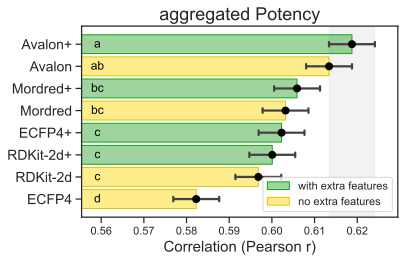

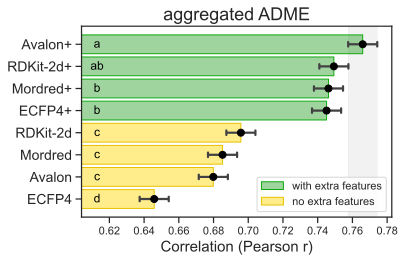

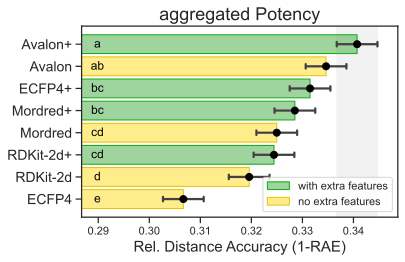

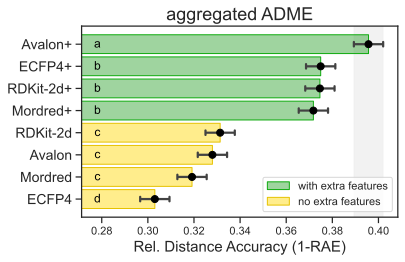

In [1047]:


group_color_dict = {
        "no extra features": "gold",
        "with extra features":  "tab:green"
}

df_model["features"] = df_model.desc_name.apply(lambda x: "with extra features" if "+" in x else "no extra features")

extra_desc_list = ["Avalon","Avalon+","RDKit-2d","RDKit-2d+","Mordred","Mordred+","ECFP4","ECFP4+"]

for target in ["aggregated Potency","aggregated ADME"]:
    df_i = df_model[df_model.model.isin(["LGBM","RF"])]
    df_i = df_i[df_model.desc_name.isin(extra_desc_list)].query(f"Set == 'Val' and target == '{target}'")
    get_tukey_barplot(df_i,metric="pearsonr",group_col="desc_name",CV_col="CV",xlabel="Correlation (Pearson r)",ylabel=None,title=target,palette=group_color_dict,hue="features",legend_title="")

for target in ["aggregated Potency","aggregated ADME"]:
    df_i = df_model[df_model.model.isin(["LGBM","RF"])]
    df_i = df_i[df_model.desc_name.isin(extra_desc_list)].query(f"Set == 'Val' and target == '{target}'")
    get_tukey_barplot(df_i,metric="RDA",group_col="desc_name",CV_col="CV",xlabel="Rel. Distance Accuracy (1-RAE)",ylabel=None,title=target,palette=group_color_dict,hue="features",legend_title="")


# Benchmarking of Model Algorithms

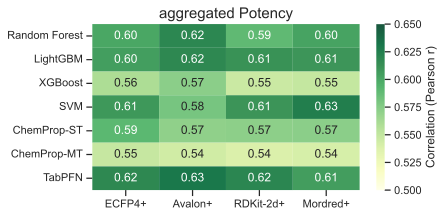

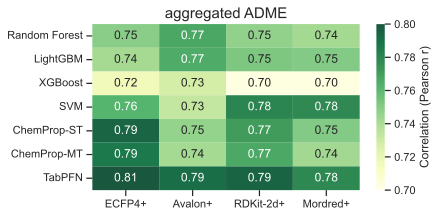

In [683]:
import seaborn as sns
fig = plt.figure(figsize=(6,3))


df_model["model_name"] = df_model["model_name"].apply(lambda x: x.replace("Support Vector Machine","SVM")) 

row_order = [ 'Random Forest', 'LightGBM', 'XGBoost', 'SVM','ChemProp-ST', 'ChemProp-MT','TabPFN']
col_order = ["ECFP4+","Avalon+","RDKit-2d+","Mordred+"]

df_model_heatmap = df_model[df_model.model_name.isin(row_order)].query(f"Set == 'Val' and target == 'aggregated Potency'").groupby(["desc_name","model_name"]).agg('mean',numeric_only=True).reset_index().pivot(index="model_name", columns="desc_name", values="pearsonr")
sns.heatmap(df_model_heatmap.loc[row_order,col_order],cmap="YlGn",
            annot=True,cbar_kws={'label': "Correlation (Pearson r)"},
            alpha=0.9, fmt=".2f",vmin=0.5,vmax=0.65) 
plt.xticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
plt.title("aggregated Potency",fontsize=15)
plt.show()

fig = plt.figure(figsize=(6,3))

df_model_heatmap = df_model[df_model.model_name.isin(row_order)].query(f"Set == 'Val' and target == 'aggregated ADME'").groupby(["desc_name","model_name"]).agg('mean',numeric_only=True).reset_index().pivot(index="model_name", columns="desc_name", values="pearsonr")
sns.heatmap(df_model_heatmap.loc[row_order,col_order],cmap="YlGn",
            annot=True,cbar_kws={'label': "Correlation (Pearson r)"},
            alpha=0.9, fmt=".2f",vmin=0.7,vmax=0.8) 
plt.xticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
plt.title("aggregated ADME",fontsize=15)
plt.show()

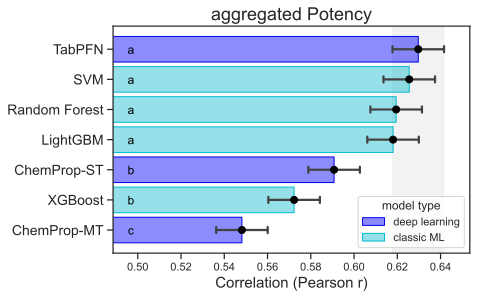

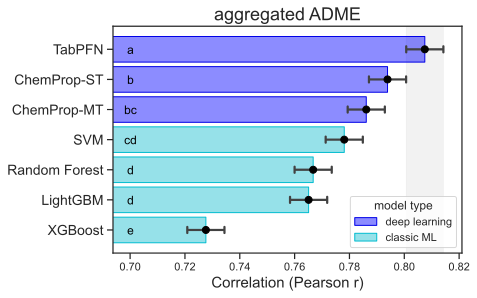

In [690]:


df_model["model_type_name"] = df_model["model type"].apply(lambda x: "deep learning" if (x in "DL")  else "classic ML")

best_model_combo_adme = df_model[df_model.desc_name.isin(["Mordred+","Avalon+","ECFP4+","RDKit2d+"])].query("Set == 'Val' and target == 'aggregated ADME'").groupby(["model_combo","model"]).agg("mean",numeric_only=True).reset_index().sort_values(by="RDA",ascending=False).drop_duplicates(subset="model").model_combo.values
best_model_combo_potency = df_model[df_model.desc_name.isin(["Mordred+","Avalon+","ECFP4+","RDKit2d+"])].query("Set == 'Val' and target == 'aggregated Potency'").groupby(["model_combo","model"]).agg("mean",numeric_only=True).reset_index().sort_values(by="RDA",ascending=False).drop_duplicates(subset="model").model_combo.values

group_color_dict = {
        "classic ML": "tab:cyan",
        "deep learning":  "blue"
}
for target in ["aggregated Potency","aggregated ADME"]:
    if target == "aggregated Potency":
        df_i = df_model[df_model.model_combo.isin(best_model_combo_potency)] #"ecfp4+","rdkit+","mordred+"
    if target == "aggregated ADME":
        df_i = df_model[df_model.model_combo.isin(best_model_combo_adme)]
        
    df_i = df_i.query(f"Set == 'Val' and target == '{target}'")
    get_tukey_barplot(df_i.query("model != 'FFN'"),metric="pearsonr",group_col="model_name",CV_col="CV",xlabel="Correlation (Pearson r)",ylabel=None,title=target,palette=group_color_dict,hue="model_type_name",legend_title="model type",figsize=(7,4))


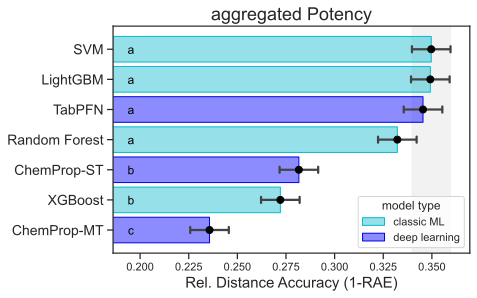

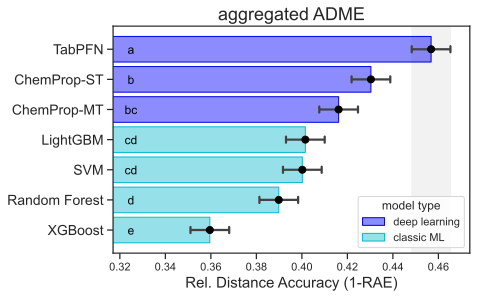

In [691]:

group_color_dict = {
        "classic ML": "tab:cyan",
        "deep learning":  "blue"
}
for target in ["aggregated Potency","aggregated ADME"]:
    if target == "aggregated Potency":
        df_i = df_model[df_model.model_combo.isin(best_model_combo_potency)] #"ecfp4+","rdkit+","mordred+"
    if target == "aggregated ADME":
        df_i = df_model[df_model.model_combo.isin(best_model_combo_adme)]
        
    df_i = df_i.query(f"Set == 'Val' and target == '{target}'")
    get_tukey_barplot(df_i.query("model != 'FFN'").sort_values(by="RAE"),metric="RDA",group_col="model_name",CV_col="CV",xlabel="Rel. Distance Accuracy (1-RAE)",ylabel=None,title=target,palette=group_color_dict,hue="model_type_name",legend_title="model type",figsize=(7,4))


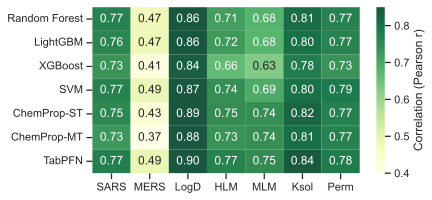

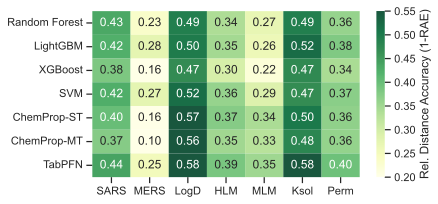

In [692]:
import seaborn as sns
fig = plt.figure(figsize=(6,3))

row_order = [ 'Random Forest', 'LightGBM', 'XGBoost', 'SVM','ChemProp-ST', 'ChemProp-MT','TabPFN']
col_order = ['SARS', 'MERS', 'LogD','HLM','MLM','Ksol','Perm']

df_heat_map_potency = df_model[df_model.model_combo.isin(best_model_combo_potency)].query("task == 'Potency' and Set == 'Val'")
df_heat_map_adme = df_model[df_model.model_combo.isin(best_model_combo_adme)].query("task == 'ADME' and Set == 'Val'")

df_model_heatmap = pd.concat([df_heat_map_potency,df_heat_map_adme],ignore_index=True).groupby(["target_name","model_name"]).agg('mean',numeric_only=True).reset_index().pivot(index="model_name", columns="target_name", values="pearsonr")

sns.heatmap(df_model_heatmap.loc[row_order,col_order],cmap="YlGn",annot=True,cbar_kws={'label': "Correlation (Pearson r)"},
            alpha=0.9, fmt=".2f",vmin=0.4,vmax=0.85) 
plt.xticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
#plt.legend()
plt.show()

fig = plt.figure(figsize=(6,3))

df_model_heatmap = pd.concat([df_heat_map_potency,df_heat_map_adme],ignore_index=True).groupby(["target_name","model_name"]).agg('mean',numeric_only=True).reset_index().pivot(index="model_name", columns="target_name", values="RDA")
sns.heatmap(df_model_heatmap.loc[row_order,col_order],cmap="YlGn",annot=True,cbar_kws={'label': "Rel. Distance Accuracy (1-RAE)"},
            alpha=0.9, fmt=".2f",vmin=0.2,vmax=0.55) 
plt.xticks(rotation=0)
plt.ylabel("")
plt.xlabel("")
#plt.legend()
plt.show()


# Test Set Leaderboard Comparison

In [704]:
import model_comparison
import importlib
importlib.reload(model_comparison)
from model_comparison import get_tukey_barplot_test

In [580]:
df_test_adme = pd.read_csv("./ADME_Test_predictions.csv")
df_test_pot = pd.read_csv("./Potency_Test_predictions.csv")
df_eval_polaris = pd.read_csv("./Test_set_boostrapped_evals.csv")

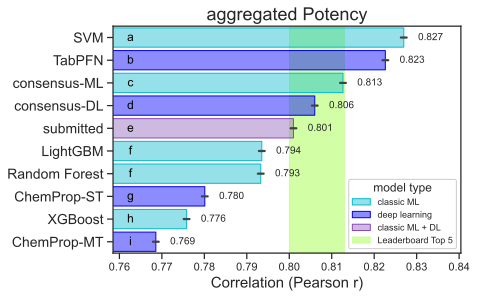

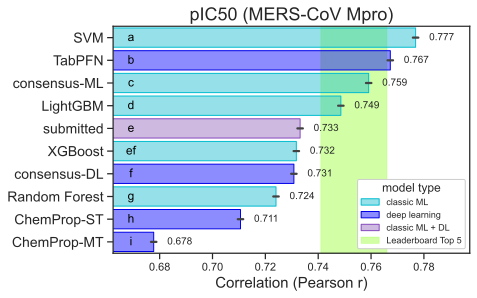

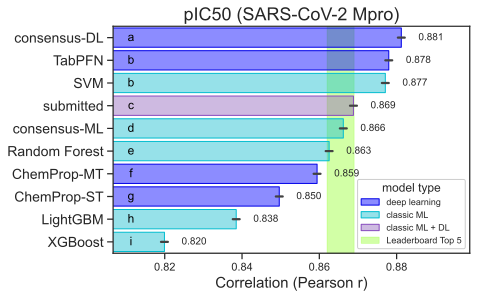

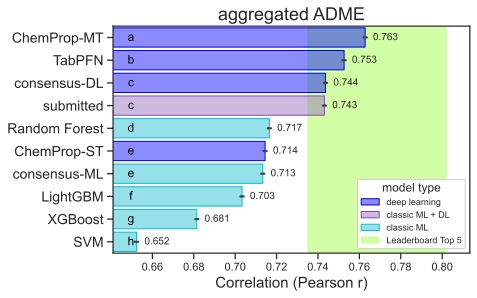

In [705]:

group_color_dict = {
        "classic ML": "tab:cyan",
        "deep learning":  "blue",
        "classic ML + DL": "tab:purple"
}

df_eval_polaris["model_name"] = df_eval_polaris["model_name"].apply(lambda x: x.replace("Support Vector Machine","SVM"))
for target in ['aggregated Potency','pIC50 (MERS-CoV Mpro)', 'pIC50 (SARS-CoV-2 Mpro)','aggregated ADME']:       
    df_i = df_eval_polaris[df_eval_polaris['Target Label'] == target].query(f"Metric == 'pearsonr' and model_name != 'consensus-all'")
    #df_i["Bootstrap Iteration"] = df_i["Bootstrap Iteration"].astype(int)
    get_tukey_barplot_test(df_i,metric="Score",group_col="model_name",CV_col="Bootstrap Iteration",
                           xlabel="Correlation (Pearson r)",ylabel=None,title=target,palette=group_color_dict,
                           hue="model_type",legend_title="model type",figsize=(7,4),ascending=False)


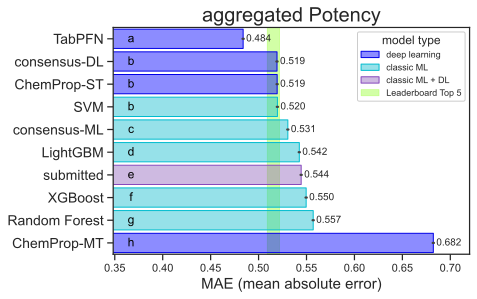

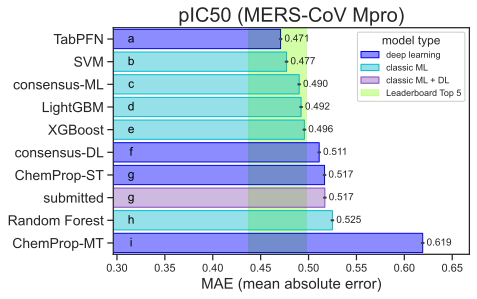

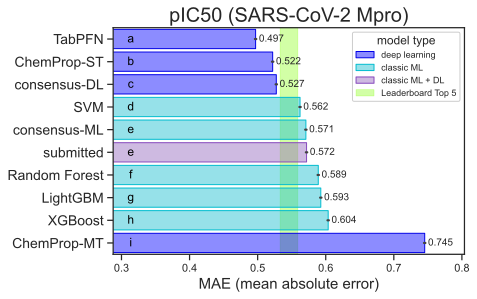

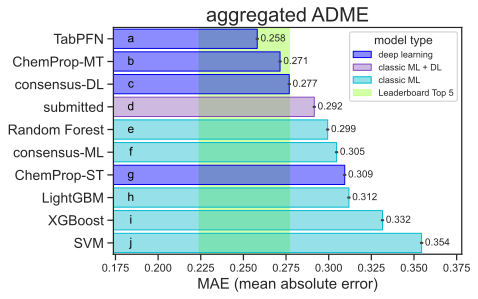

In [699]:
for target in ['aggregated Potency','pIC50 (MERS-CoV Mpro)', 'pIC50 (SARS-CoV-2 Mpro)','aggregated ADME']:       
    df_i = df_eval_polaris[df_eval_polaris['Target Label'] == target].query(f"Metric == 'mean_absolute_error' and model_name != 'consensus-all'")
    #df_i["Bootstrap Iteration"] = df_i["Bootstrap Iteration"].astype(int)
    get_tukey_barplot_test(df_i,metric="Score",group_col="model_name",CV_col="Bootstrap Iteration",
                           xlabel="MAE (mean absolute error)",ylabel=None,title=target,palette=group_color_dict,
                           hue="model_type",legend_title="model type",figsize=(7,4),ascending=True)


# Impact of Training set similarity on prediction error

In [591]:
def plot_parity(df,df_true,endpoints=['LogD', 'LogHLM', 'LogMLM', 'LogKSOL', 'LogMDR1'],model_list=["consensus-ML","consensus-DL"],marker_list=["o","s"],task="adme"):
    for endpoint in endpoints:
        y_true = df_true.query("Set == 'Test'")[endpoint].values
        sim = df_true.query("Set == 'Test'")["train_test_sim"].values
        y_min = np.nanmin(y_true)
        y_max = np.nanmax(y_true)
        for i,model in enumerate(model_list):
            y_pred =  df[[col for col in df.columns if (endpoint in col and model in col) ]].median(axis=1)
            plt.scatter(x=y_true, y=y_pred,marker=marker_list[i],zorder=1,ec='white',alpha=0.9,c=sim,cmap="RdYlBu",s=70,lw=0.5,vmin=0.35,vmax=0.9)
            if i == 0:
                cbar = plt.colorbar()
                cbar.set_label("Tan. sim. with training set", fontsize=15)
                cbar.ax.tick_params(labelsize=12)
            plt.scatter([-10,-10],[-10,-10],ec="black",marker=marker_list[i],color="#A9A9A9",
                        label=f"{model.replace("consensus-","").replace("RF",r"ML$_{RF}$").replace("TAB",r"DL$_{TabPFN}$").replace("SVR",r"ML$_{SVM}$")}: r={get_regression_stats(y_true,y_pred).get("pearsonr"):.2f} | MAE={get_regression_stats(y_true,y_pred).get("MAE"):.2f}")
            y_min = min([y_min,np.nanmin(y_pred)])
            y_max = max([y_max,np.nanmax(y_pred)])
        plt.xlabel(f"Experimental",fontsize=18)
        plt.ylabel(f"Predicted",fontsize=18)
        parity = np.array([0.9*y_min, 1.05*y_max])
        plt.plot(parity,parity,color='gray',zorder=0)
        plt.fill_between(parity, parity - 0.5, parity + 0.5, alpha=0.2,color="gray",zorder=0)
        plt.fill_between(parity, parity - 1, parity + 1, alpha=0.1,color="gray",zorder=0)
        plt.xlim(parity)
        plt.ylim(parity)
        plt.legend(loc="upper left",fontsize=13)
        plt.title(endpoint.replace("MDR1","Perm"),fontsize=20)
        plt.show()   

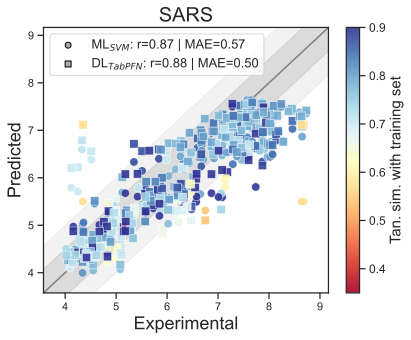

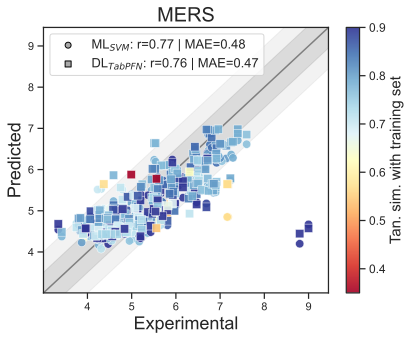

In [592]:
plot_parity(df_test_pot,df_pot,endpoints=['SARS','MERS'],model_list=["SVR","TAB"])

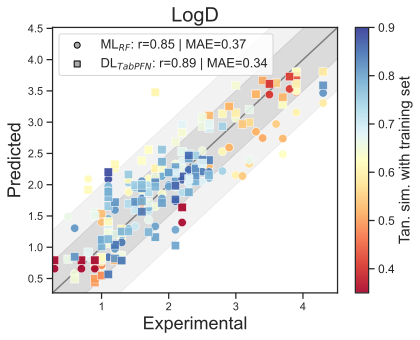

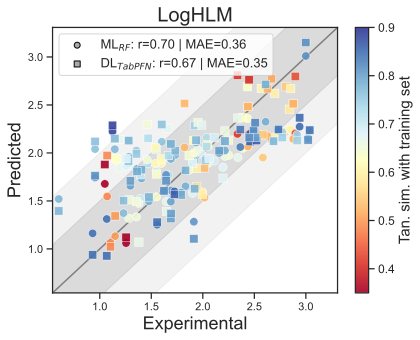

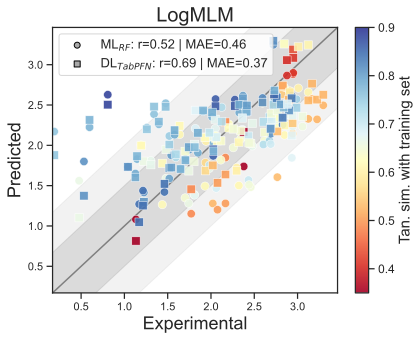

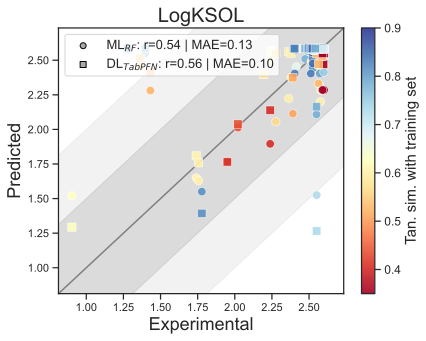

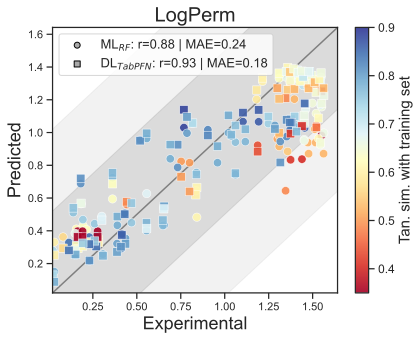

In [593]:
plot_parity(df_test_adme,df_adme,endpoints=['LogD', 'LogHLM', 'LogMLM', 'LogKSOL', 'LogMDR1'],model_list=["RF","TAB"])

In [618]:
adme_log_endpoints = ["LogD",'LogHLM', 'LogMLM', 'LogKSOL', 'LogMDR1']
df_adme_resid = pd.concat([df_adme[["CXSMILES","Molecule Name","train_test_sim","Set"]+adme_log_endpoints].query("Set == 'Test'").reset_index(drop=True),
                           df_test_adme],axis=1)

median_adme_sim = df_adme.query("Set == 'Test'").train_test_sim.median()
df_adme_resid["similarity"] =  df_adme_resid["train_test_sim"].apply(lambda x: "high" if x > median_adme_sim  else "low")

for endpoint in adme_log_endpoints:
    for model in ["TAB","RF"]:
        df_adme_resid[f"resid_{model}_{endpoint}"] = np.abs(df_adme_resid[endpoint].values -  df_adme_resid[f"{model}_{endpoint}"].values) 

In [619]:
df_pot_resid = pd.concat([df_pot[["CXSMILES","Molecule Name","train_test_sim","Set"]+["SARS","MERS"]].query("Set == 'Test'").reset_index(drop=True),df_test_pot],axis=1)
median_pot_sim = df_pot.query("Set == 'Test'").train_test_sim.median()
df_pot_resid["similarity"] =  df_pot_resid.train_test_sim.apply(lambda x: "high" if x > median_pot_sim else "low")


for endpoint in ["SARS","MERS"]:
    for model in ["TAB","SVR"]:
        df_pot_resid[f"resid_{model}_{endpoint}"] = np.abs(df_pot_resid[endpoint].values -  df_pot_resid[f"{model}_{endpoint}"].values) 

In [616]:
df_pot_for_melt = df_pot_resid[["CXSMILES","Molecule Name","train_test_sim","similarity"] + [col for col in df_pot_resid.columns if "resid" in col]]
df_adme_for_melt = df_adme_resid[["CXSMILES","Molecule Name","train_test_sim","similarity"] + [col for col in df_adme_resid.columns if "resid" in col]]

In [630]:

df_pot_resid_melt = pd.melt(df_pot_for_melt, 
            id_vars=['CXSMILES','Molecule Name',"train_test_sim","similarity"],
            value_vars=list(df_pot_for_melt.columns[3:]), 
            var_name='model', 
            value_name='abs_resid')

df_pot_resid_melt["task"] = "Potency"
df_pot_resid_melt["target"] = df_pot_resid_melt.model.apply(lambda x: x.split(sep='_')[-1])
df_pot_resid_melt["model_name"] = df_pot_resid_melt.model.apply(lambda x: x.split(sep='_')[-2])
df_pot_resid_melt["model_type"] = df_pot_resid_melt.model_name.apply(lambda x: "DL" if "TAB" in x else "ML")

df_adme_resid_melt = pd.melt(df_adme_for_melt, 
            id_vars=['CXSMILES','Molecule Name',"train_test_sim","similarity"],
            value_vars=list(df_adme_for_melt.columns[3:]), 
            var_name='model', 
            value_name='abs_resid')

df_adme_resid_melt["task"] = "ADME"
df_adme_resid_melt["target"] = df_adme_resid_melt.model.apply(lambda x: x.split(sep='_')[-1])
df_adme_resid_melt["model_name"] = df_adme_resid_melt.model.apply(lambda x: x.split(sep='_')[-2])
df_adme_resid_melt["model_type"] = df_adme_resid_melt.model_name.apply(lambda x: "DL" if "TAB" in x else "ML")

df_resid_concat = pd.concat([df_pot_resid_melt,df_adme_resid_melt],ignore_index=True)


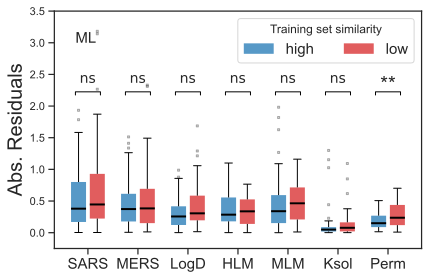

In [720]:
sns.set(style="ticks")
plt.figure(figsize=(6, 4))
from scipy.stats import mannwhitneyu


flierprops = dict(marker='s', markersize=2, markerfacecolor='gray', alpha=0.3)

ax = sns.boxplot(df_resid_concat.query("model_type == 'ML'"),
    x="target", y="abs_resid", hue="similarity",showfliers=True, width=0.75,gap=0.2,palette=["tab:blue","tab:red"],linewidth=1,linecolor='black',
    medianprops={"color": "black", "linewidth": 2},boxprops={"linewidth": 0,"alpha":0.75},flierprops=flierprops, saturation=1)

pval_mann = [mannwhitneyu(df_resid_concat.query("model_type == 'ML'").query(f"target =='{i}' and similarity == 'high'")["abs_resid"].dropna()
                           , df_resid_concat.query("model_type == 'ML'").query(f"target =='{i}' and similarity == 'low'")["abs_resid"].dropna(),
                           alternative='two-sided') for i in df_resid_concat.target.unique()]

plt.xlabel("",fontsize=8)
plt.ylabel("Abs. Residuals", fontsize=20)

handles, labels = ax.get_legend_handles_labels()

y_position = 2.2
ax.set_xticklabels(["SARS", "MERS", "LogD", "HLM","MLM","Ksol","Perm"],fontsize=15)

plt.legend(title="Training set similarity",loc="upper right",fontsize=15,ncols=2)
for i,endpoint in enumerate(df_resid_concat.target.unique()):
    y=y_position-0.025 ; h=0.05
    x1 = i-0.25
    x2 = i+0.25
    plt.text(x=np.mean([x1,x2]), y=y+h+0.02, s=pval_to_asterisk(pval_mann[i].pvalue),fontsize=20, ha='center')
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, color="black")


plt.tight_layout() 
plt.ylim([-0.25,3.5])
plt.annotate("ML",(-0.25,3),fontsize=15)
plt.show()

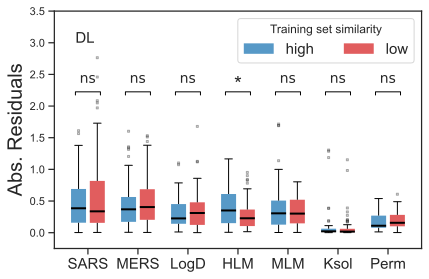

In [721]:
sns.set(style="ticks")
plt.figure(figsize=(6, 4))
from scipy.stats import mannwhitneyu


flierprops = dict(marker='s', markersize=2, markerfacecolor='gray', alpha=0.3)

ax = sns.boxplot(df_resid_concat.query("model_type == 'DL'"),
    x="target", y="abs_resid", hue="similarity",showfliers=True, width=0.75,gap=0.2,palette=["tab:blue","tab:red"],linewidth=1,linecolor='black',
    medianprops={"color": "black", "linewidth": 2},boxprops={"linewidth": 0,"alpha":0.75},flierprops=flierprops, saturation=1)

pval_mann = [mannwhitneyu(df_resid_concat.query("model_type == 'DL'").query(f"target =='{i}' and similarity == 'high'")["abs_resid"].dropna()
                           , df_resid_concat.query("model_type == 'DL'").query(f"target =='{i}' and similarity == 'low'")["abs_resid"].dropna(),
                           alternative='two-sided') for i in df_resid_concat.target.unique()]

plt.xlabel("",fontsize=8)
plt.ylabel("Abs. Residuals", fontsize=20)

handles, labels = ax.get_legend_handles_labels()

y_position = 2.2
ax.set_xticklabels(["SARS", "MERS", "LogD", "HLM","MLM","Ksol","Perm"],fontsize=15)

plt.legend(title="Training set similarity",loc="upper right",fontsize=15,ncols=2)
for i,endpoint in enumerate(df_resid_concat.target.unique()):
    y=y_position-0.025 ; h=0.05
    x1 = i-0.25
    x2 = i+0.25
    plt.text(x=np.mean([x1,x2]), y=y+h+0.02, s=pval_to_asterisk(pval_mann[i].pvalue),fontsize=20, ha='center')
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, color="black")


plt.tight_layout() 
plt.annotate("DL",(-0.25,3),fontsize=15)
plt.ylim([-0.25,3.5])
plt.show()

## Check if parametric t-test gives similar results

In [665]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
pval_ttest = [stats.ttest_ind(df_resid_concat.query("model_type == 'ML'").query(f"target =='{i}' and similarity == 'high'")["abs_resid"].dropna()
                           , df_resid_concat.query("model_type == 'ML'").query(f"target =='{i}' and similarity == 'low'")["abs_resid"].dropna()) for i in df_resid_concat.target.unique()]

p_values = [t.pvalue for t in pval_ttest]

# Apply multiple comparison correction (Bonferroni)
reject, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

print("Original p-values:", p_values)
print("Corrected p-values:", p_corrected)
print("Reject H0 after correction:", reject)


Original p-values: [np.float64(0.1576173274838266), np.float64(0.9617386178379023), np.float64(0.04496224478932839), np.float64(0.5385869253606757), np.float64(0.8906063734422436), np.float64(0.9159870922100424), np.float64(0.0013346803411197236)]
Corrected p-values: [1.         1.         0.31473571 1.         1.         1.
 0.00934276]
Reject H0 after correction: [False False False False False False  True]


In [663]:
from scipy import stats
from statsmodels.stats.multitest import multipletests
pval_ttest = [stats.ttest_ind(df_resid_concat.query("model_type == 'DL'").query(f"target =='{i}' and similarity == 'high'")["abs_resid"].dropna()
                           , df_resid_concat.query("model_type == 'DL'").query(f"target =='{i}' and similarity == 'low'")["abs_resid"].dropna()) for i in df_resid_concat.target.unique()]

p_values = [t.pvalue for t in pval_ttest]

# Apply multiple comparison correction (Bonferroni)
reject, p_corrected, _, _ = multipletests(p_values, method='bonferroni')

print("Original p-values:", p_values)
print("Corrected p-values:", p_corrected)
print("Reject H0 after correction:", reject)


Original p-values: [np.float64(0.18222682575596552), np.float64(0.9405187550118921), np.float64(0.4481538679547086), np.float64(0.03760743373756254), np.float64(0.1813041831413876), np.float64(0.41306346024555884), np.float64(0.48424558936598383)]
Corrected p-values: [1.         1.         1.         0.26325204 1.         1.
 1.        ]
Reject H0 after correction: [False False False False False False False]
